In [80]:
import reframed
from pathlib import Path
import pandas as pd
import numpy as np
import sys
sys.path.append('../code')
sys.path.append('../../mwf_gems/code/python')
import leakage_reframed
import ng_utils

import utils
from dFBA_reframed import dFBA, FBA_with_leakage2, get_leaky_metabolites, FBA_with_leakage
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy

In [3]:
def predict_leakage_rates_from_sp(model, leak_mets, leak_exchanges, shadow_prices,
                                  slope, intercept, noise = None):
    rate_noise = np.zeros(len(leak_mets))
    if isinstance(noise, dict):
        if noise.get('slope'):
            slope_noise = np.random.normal(0, noise['slope'])
            slope = slope + slope_noise
            logging.info(f'Slope noise: {slope_noise}')

        if noise.get('rates'):
            rate_noise = np.random.normal(0, noise['rates'], len(leak_mets))
            logging.info(f"Adding rate noise with std: {noise['rates']}")
    predicted_log_leakage_rates = {}
    predicted_metabolite_values = {}
    for i, (m_id, r_ex_id) in enumerate(zip(leak_mets, leak_exchanges)):
        metabolite_value = -shadow_prices[m_id]
        if np.isfinite(metabolite_value) and metabolite_value > 1e-7:
            # Use trendline from fit 
            lograte = intercept + slope*np.log10(metabolite_value) + rate_noise[i]
            # print(m_id, np.log10(metabolite_value), lograte)
            predicted_log_leakage_rates[r_ex_id] = lograte
    return predicted_log_leakage_rates
    

def predict_log_leakage_rates(model, constraints, fraction_of_optimum, slope, intercept, noise = None):
    leak_mets, leak_exchanges = get_leaky_metabolites(model, constraints=constraints,
                                                      fraction_of_optimum=fraction_of_optimum)
    
    shadow_prices = leakage_reframed.estimate_shadow_prices(model, constraints=constraints,
                                                            metabolites = leak_mets)
    log_leakage_rates = predict_leakage_rates_from_sp(model, 
                                    leak_mets, leak_exchanges, shadow_prices,
                                    slope, intercept, noise = noise)
    return log_leakage_rates
    
    

# Mapping

In [4]:
mapping_df = pd.read_csv('../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Load model

In [5]:
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
# model = reframed.load_cbmodel('../models/e_coli/iJO1366.xml')
model.solver = 'gurobi'
for r_id in model.get_exchange_reactions():
    if model.reactions[r_id].ub == 0:
        model.reactions[r_id].ub = 1000
model.reactions.R_ER_pool_TG_.ub = 0.095
model.reactions.R_ATPM.lb = 3.15
model.reactions.R_EX_cbl1_e.lb = -0.01

In [6]:
sol = reframed.FBA(model, constraints={'R_EX_glc__D_e':-10})
sol.show_values('BIOMA')

Set parameter Username


2023-12-13 10:21:12 INFO:gurobipy.gurobipy Set parameter Username


Academic license - for non-commercial use only - expires 2024-02-26


2023-12-13 10:21:12 INFO:gurobipy.gurobipy Academic license - for non-commercial use only - expires 2024-02-26


R_BIOMASS_Ec_iJO1366_core_53p95M  0.704473


# Load data from paczia

In [7]:
data_folder =  Path("../data/e_coli/")
organism = 'e_coli'

In [8]:
ecoli_gDW_per_OD = 0.32

In [9]:
exometabolites_folder = Path(data_folder)

# Filenames
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

# Read files as dataframes
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [10]:
df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [11]:
# mmol/gDW/h
measured_leakage_rate = {'G6P': 0.0010438761283126908,
 'F6P': 0.001720037214288813,
 'FBP': 0.000596339084436308,
 'DHAP': 0.0017176988667935021,
 'GA3P': 0.00036506899822389257,
 '23PG': 0.0005704583195396499,
 'PEP': 0.0001870830349953417,
 'R5P': 0.0002577601755898069,
 'RU5P+X5P': 0.00011597389234638379,
 'E4P': 6.557017551691731e-05,
 'CIT': 0.007723297310963466,
 'ACN': 0.0007720359996694818,
 'ICIT': 0.0009509267679088724,
 'OAS': 0.00016911827635094167,
 'GLU': 1.7877922829593983e-05,
 'SER': 6.472649365988079e-06,
 'ASP': 4.9480288006758606e-05,
 'THR': 0.00012063788397414984,
 'HOM': 9.86093578992601e-05,
 'TYR': 6.984309404403658e-06,
 'GLY': 2.8440197370474055e-05,
 'PRO': 2.5795461110732794e-05,
 'ALA': 0.0001046368516559598,
 'MET': 9.124717030733685e-06,
 'VAL': 5.130530390372902e-05,
 'PHE': 1.6431976758965484e-05,
 'ILEU': 6.459028052273799e-05,
 'LEU': 6.298291340417741e-05,
 'TRP': 7.73214549522216e-06,
 'HIS': 0.0002819625922307103,
 'ARG': 0.0008906846322060193,
 'PYR': 0.49103339770631516,
 'ORO': 0.0988523960866463,
 'FUM': 0.00036523132723280144,
 'URA': -0.001443204591261334,
 'AKG': 0.0005211649837775554,
 'ACT': 1.3042632384458672}

In [12]:
leak_exchanges = []
leak_mets = []
measured_leakage_rate_ex = {}
for met_abbr, value in measured_leakage_rate.items():
    if value < 0:
        continue
    m_ids = met_abrv_to_id[met_abbr].split(', ')
    for bigg_id in m_ids:
        r_id = f'R_EX_{bigg_id}_e'
        if r_id in model.reactions:
            measured_leakage_rate_ex[r_id] = value/len(m_ids)
            leak_exchanges.append(r_id)
            leak_mets.append(f'M_{bigg_id}_c')
        else:
            print(r_id)

R_EX_fdp_e
R_EX_dhap_e
R_EX_g3p_e
R_EX_2pg_e
R_EX_3pg_e
R_EX_pep_e
R_EX_ru5p__D_e
R_EX_ru5p__L_e
R_EX_xu5p__D_e
R_EX_xu5p__L_e
R_EX_e4p_e
R_EX_acon_C_e
R_EX_icit_e
R_EX_oaa_e


In [13]:
measured_leakage_rate_ex

{'R_EX_g6p_e': 0.0010438761283126908,
 'R_EX_f6p_e': 0.001720037214288813,
 'R_EX_r5p_e': 0.0002577601755898069,
 'R_EX_cit_e': 0.007723297310963466,
 'R_EX_glu__L_e': 1.7877922829593983e-05,
 'R_EX_ser__L_e': 6.472649365988079e-06,
 'R_EX_asp__L_e': 4.9480288006758606e-05,
 'R_EX_thr__L_e': 0.00012063788397414984,
 'R_EX_hom__L_e': 9.86093578992601e-05,
 'R_EX_tyr__L_e': 6.984309404403658e-06,
 'R_EX_gly_e': 2.8440197370474055e-05,
 'R_EX_pro__L_e': 2.5795461110732794e-05,
 'R_EX_ala__L_e': 0.0001046368516559598,
 'R_EX_met__L_e': 9.124717030733685e-06,
 'R_EX_val__L_e': 5.130530390372902e-05,
 'R_EX_phe__L_e': 1.6431976758965484e-05,
 'R_EX_ile__L_e': 6.459028052273799e-05,
 'R_EX_leu__L_e': 6.298291340417741e-05,
 'R_EX_trp__L_e': 7.73214549522216e-06,
 'R_EX_his__L_e': 0.0002819625922307103,
 'R_EX_arg__L_e': 0.0008906846322060193,
 'R_EX_pyr_e': 0.49103339770631516,
 'R_EX_orot_e': 0.0988523960866463,
 'R_EX_fum_e': 0.00036523132723280144,
 'R_EX_akg_e': 0.0005211649837775554,
 'R

# Estimate max glucose uptake rate
Answer = 8 mmol/gDW/h

In [14]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [15]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*0.32
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

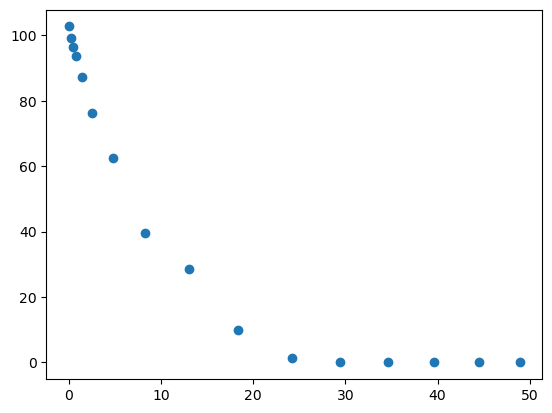

In [16]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [17]:
np.polyfit(df_OD.loc[1:7, 'Cum OD gDW'], df_glucose.loc[1:7, 'Glucose mM'], 1)

array([ -8.39201233, 100.36575098])

# Run FBA

In [18]:
solution = reframed.FBA(model, constraints={'R_EX_glc__D_e': (-8,0), 'R_ER_pool_TG_':(0,0.06)})

In [19]:
solution.show_values('pool')
solution.show_values('EX')

R_ER_pool_TG_  0.06
R_EX_ac_e     8.54167
R_EX_ca2_e   -0.00237819
R_EX_cl_e    -0.00237819
R_EX_co2_e    12.1615
R_EX_cobalt2_e -1.14226e-05
R_EX_cu2_e   -0.000323945
R_EX_fe2_e   -0.00733835
R_EX_glc__D_e -8
R_EX_h_e      12.7398
R_EX_h2o_e    24.2282
R_EX_k_e     -0.0891846
R_EX_meoh_e   9.13809e-07
R_EX_mg2_e   -0.00396365
R_EX_mn2_e   -0.000315721
R_EX_mobd_e  -5.89407e-05
R_EX_nh4_e   -4.93495
R_EX_ni2_e   -0.00014758
R_EX_o2_e    -11.1865
R_EX_pi_e    -0.440744
R_EX_so4_e   -0.115236
R_EX_zn2_e   -0.000155805
R_HEX1        8


## Add exchanges

In [20]:
measured_exchanges = []
for met_abbr, id_string in met_abrv_to_id.items():
    if not isinstance(id_string, str):
        continue
    for m_id in id_string.split(','):
        r_id = f'R_EX_{m_id}_e'
        if r_id in model.reactions:
            measured_exchanges.append(r_id)



In [21]:
fva = reframed.FVA(model, obj_frac = 0.9, reactions=measured_exchanges, constraints={'R_EX_glc__D_e':-10})
# fva = reframed.FVA(model, obj_frac = 0.9, reactions=measured_exchanges, 
#                    constraints={'R_EX_glc__D_e': (-8,0), 'R_EX_nh4_e': (-7,0)})


## Compare predicted shadow prices with estimated rates now

In [22]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'M_{m_id}_c' in model.metabolites:
            measured_metabolites.append(f'M_{m_id}_c')

In [23]:
# measured_metabolites =[f'M_{m_id}_c' for m_id in met_abrv_to_id.values() if f'M_{m_id}_c' in model.metabolites]

shadow_prices = leakage_reframed.estimate_shadow_prices(model, constraints={'R_EX_glc__D_e': (-8,0)}, metabolites = measured_metabolites)

In [24]:
log10mv = {key: np.log10(-sp) for key, sp in shadow_prices.items() if sp<0}

In [79]:
m = model.metabolites.M_12dgr140_p
m.metadata['FORMULA']

{'id': 'M_12dgr140_p',
 'name': '1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)',
 'compartment': 'p',
 'metadata': OrderedDict([('FORMULA', 'C31H60O5'),
              ('CHARGE', '0'),
              ('bigg.metabolite', ['12dgr140']),
              ('metanetx.chemical', ['MNXM146479'])])}

In [71]:
mv = {key: -sp for key, sp in shadow_prices.items() if sp<0}

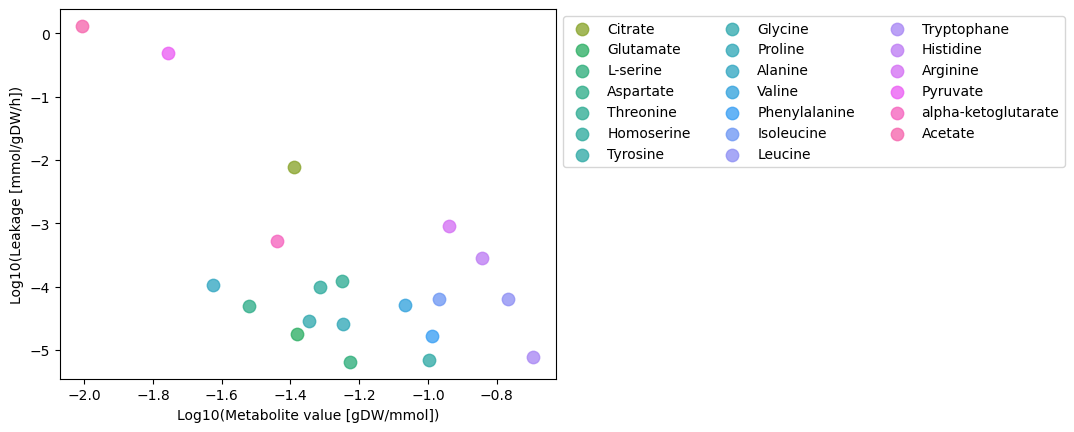

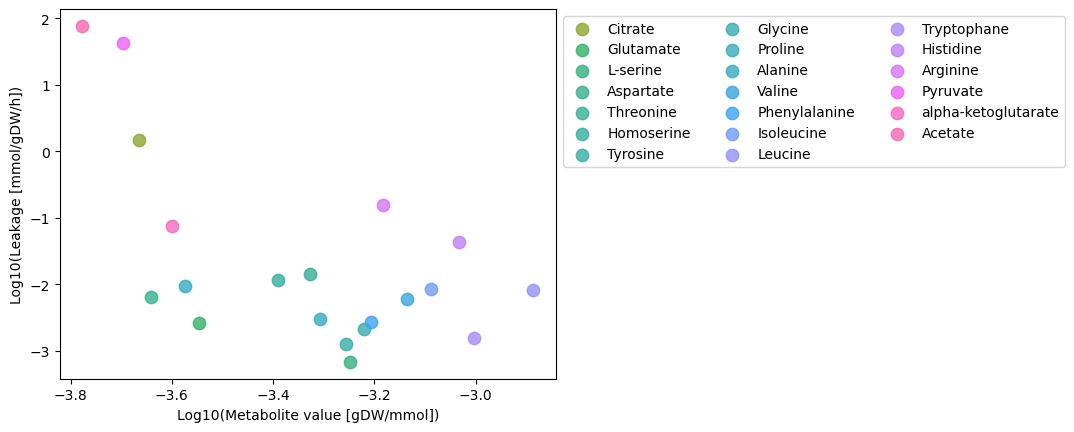

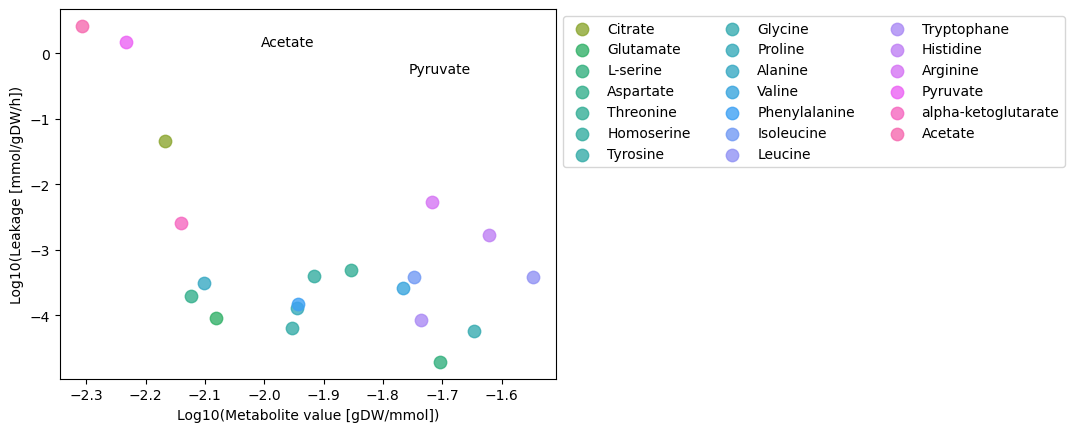

In [85]:
data = []
i = 0
fig1, ax1 = plt.subplots(1)
fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
NUM_COLORS = len(measured_leakage_rate)
clrs = sns.color_palette('husl', n_colors=NUM_COLORS)
for met_abbr, leakage in measured_leakage_rate.items():
    
    if leakage < 0:
        continue
    log10_leakage = np.log10(leakage)
    bigg_id =  met_abrv_to_id[met_abbr]
    name = met_abrv_to_name[met_abbr]
    m_ids = bigg_id.split(', ')
    mv_sum = 0
    mv_Mnorm_sum = 0
    mv_Cnorm_sum = 0
    mv_count = 0
    for m_id in m_ids:
        try:
            m = model.metabolites[f'M_{m_id}_c']
            mv_sum += mv[f'M_{m_id}_c']
            mv_Mnorm_sum += mv[f'M_{m_id}_c'] / ng_utils.get_mol_weight(m)
            mv_Cnorm_sum += mv[f'M_{m_id}_c'] / ng_utils.get_element_dict(m)['C']
            mv_count += 1
        except KeyError:
            pass
    if mv_sum != 0:
        mean_mv = mv_sum/mv_count
        mean_mvM = mv_Mnorm_sum/mv_count
        mean_mvC = mv_Cnorm_sum/mv_count
        
        log10_mv = np.log10(mean_mv)
        log10_mvM = np.log10(mean_mvM)
        log10_mvC = np.log10(mean_mvC)

        log10_leakageC = np.log10(leakage*ng_utils.get_element_dict(m)['C'])
        log10_leakageM = np.log10(leakage*ng_utils.get_mol_weight(m))
        
        ax1.scatter(log10_mv, log10_leakage, label = name, s = 80, alpha = 0.8, color = clrs[i])
        ax2.scatter(log10_mvM, log10_leakageM, label = name, s = 80, alpha = 0.8, color = clrs[i])
        ax3.scatter(log10_mvC, log10_leakageC, label = name, s = 80, alpha = 0.8, color = clrs[i])
        if (log10_leakage > -2) or (log10_mv > -1):
            plt.annotate(name, (log10_mv, log10_leakage))
        data.append([log10_mv, log10_leakage, log10_mvM, log10_leakageM, log10_mvC, log10_leakageC, name])
    i+=1
for ax in [ax1,ax2,ax3]:
    ax.legend(bbox_to_anchor = (1,1), ncol = 3)
    ax.set_xlabel('Log10(Metabolite value [gDW/mmol])')
    ax.set_ylabel('Log10(Leakage [mmol/gDW/h])')
df_leak = pd.DataFrame(data, columns = ['Log10(Metabolite value)', 'Log10(Leakage rate)','Log10(M-norm Metabolite value)', 'Log10(M-norm Leakage rate)', 'Log10(C-norm Metabolite value)', 'Log10(C-norm Leakage rate)','Metabolite'])

2023-12-14 15:14:48 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



-0.6461986333779897 0.0020822268125559283
-0.42255639097744363 0.06344083999820868
[-2.79580608 -7.22253089]


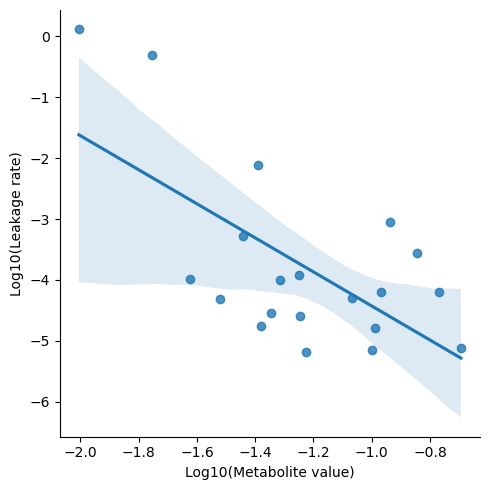

In [86]:
sns.lmplot(data = df_leak, x = 'Log10(Metabolite value)', y = 'Log10(Leakage rate)')
pcorr, ppval = scipy.stats.pearsonr(df_leak['Log10(Metabolite value)'], df_leak['Log10(Leakage rate)'])
scorr, spval = scipy.stats.spearmanr(df_leak['Log10(Metabolite value)'], df_leak['Log10(Leakage rate)'])

print(pcorr, ppval)
print(scorr, spval)

leakage_fit = np.polyfit(df_leak['Log10(Metabolite value)'], df_leak['Log10(Leakage rate)'], 1)
print(leakage_fit)

2023-12-14 15:16:23 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



-0.5903998239408746 0.006132427064616212
-0.45563909774436084 0.043493409805465975
[ -3.20757198 -12.37023166]


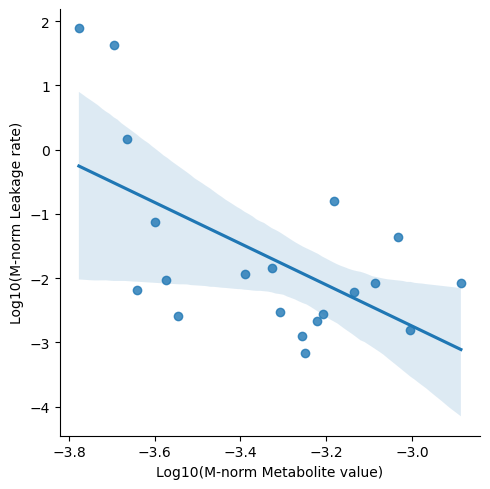

In [90]:
x = 'Log10(M-norm Metabolite value)'
y = 'Log10(M-norm Leakage rate)'
sns.lmplot(data = df_leak, x = x, y = y)
pcorr, ppval = scipy.stats.pearsonr(df_leak[x], df_leak[y])
scorr, spval = scipy.stats.spearmanr(df_leak[x], df_leak[y])

print(pcorr, ppval)
print(scorr, spval)

leakage_fit = np.polyfit(df_leak[x], df_leak[y], 1)
print(leakage_fit)

2023-12-14 15:16:19 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



-0.5723947364714738 0.008353475137663078
-0.39097744360902253 0.08828010210661397
[-3.56133229 -9.89641742]


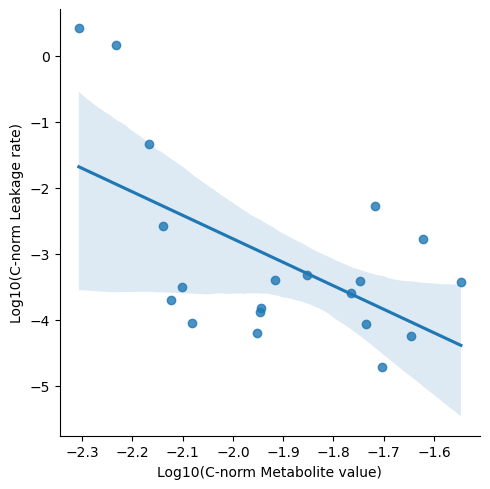

In [89]:
x = 'Log10(C-norm Metabolite value)'
y = 'Log10(C-norm Leakage rate)'
sns.lmplot(data = df_leak, x = x, y = y)
pcorr, ppval = scipy.stats.pearsonr(df_leak[x], df_leak[y])
scorr, spval = scipy.stats.spearmanr(df_leak[x], df_leak[y])

print(pcorr, ppval)
print(scorr, spval)

leakage_fit = np.polyfit(df_leak[x], df_leak[y], 1)
print(leakage_fit)

In [27]:
# mets_without_transport = []
# for r_id, fva_res in fva.items():
#     if fva_res[1] <= 0:
#         m_id = r_id[5:-2]
#         try:
#             r_ids_p = model.get_metabolite_reactions(f'M_{m_id}_p')
#         except KeyError:
#             mets_without_transport.append(m_id)
#         else:
#             r_ids_c = model.get_metabolite_reactions(f'M_{m_id}_c')
#             transport_reactions = [x for x in r_ids_c if x in r_ids_p]
#             for r_id in transport_reactions:
#                 model.reactions[r_id].lb = -1000
# model.reactions.R_R5PPpp.lb = -1000

In [28]:
# fva = reframed.FVA(model, obj_frac = 0.9, reactions=measured_exchanges, constraints={'R_EX_glc__D_e':-10})

In [29]:
# for r_id, fva_res in fva.items():
#     if fva_res[1] <= 0:
#         measured_exchanges.remove(r_id)

In [30]:
# fba_predictions = {x: solution.values[x] for x in leak_exchanges}
# for r_id, flux in fba_predictions.items():
#     if flux >0:
#         predicted_log_leakage_rates[r_id] = np.log10(flux)

# FBA

In [31]:
# temp = model.copy()
# solution = FBA_with_leakage2(temp, constraints={'R_EX_glc__D_e': -10}, fraction_of_optimum=0.8,
#                            log_leakage_rates=predicted_log_leakage_rates, leak_mets=leak_mets,
#                            leak_exchanges = leak_exchanges)

In [32]:
temp = model.copy()
log10_leakage = {key:np.log10(x) for key, x in measured_leakage_rate_ex.items()}
solution = FBA_with_leakage2(temp, constraints={'R_EX_glc__D_e': -10}, fraction_of_optimum=0.8,
                           log_leakage_rates=log10_leakage, leak_mets=leak_mets,
                           leak_exchanges = leak_exchanges)

In [33]:
solution.show_values('EX')

R_EX_ca2_e   -0.0040906
R_EX_cl_e    -0.0040906
R_EX_co2_e    16.7401
R_EX_cobalt2_e -1.96474e-05
R_EX_colipa_e  0.0242965
R_EX_cu2_e   -0.000557201
R_EX_fe2_e   -0.0126223
R_EX_glc__D_e -10
R_EX_h_e      9.50015
R_EX_h2o_e    40.6031
R_EX_indole_e  0.313251
R_EX_k_e     -0.153402
R_EX_meoh_e   1.57179e-06
R_EX_mg2_e   -0.00681766
R_EX_mn2_e   -0.000543055
R_EX_mobd_e  -0.000101381
R_EX_nh4_e   -8.86862
R_EX_ni2_e   -0.000253845
R_EX_o2_e    -14.2311
R_EX_pi_e    -0.855287
R_EX_so4_e   -0.198211
R_EX_ump_e   -1.1269e-07
R_EX_zn2_e   -0.000267991
R_EX_cit_e_r  0.00773639
R_EX_glu__L_e_r  0.000750331
R_EX_ser__L_e_r  0.000687298
R_EX_asp__L_e_r  0.00081349
R_EX_thr__L_e_r  0.000868783
R_EX_hom__L_e_r  0.000856274
R_EX_tyr__L_e_r  0.000692018
R_EX_gly_e_r  0.000779133
R_EX_pro__L_e_r  0.000773078
R_EX_ala__L_e_r  0.000859955
R_EX_val__L_e_r  0.000815738
R_EX_phe__L_e_r  0.000745099
R_EX_ile__L_e_r  0.000830024
R_EX_leu__L_e_r  0.00082846
R_EX_trp__L_e_r  0.000698329
R_EX_his__L_e_r  0.000

In [34]:
# fig, ax = plt.subplots(1)
# for r_id,m_id in zip(leak_exchanges, shadow_prices):
#     leakage = solution.values[f'{r_id}_r']
#     sp = shadow_prices[m_id]
#     # ax.scatter(np.log10(-sp), np.log10(-leakage), label = m_id)
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# # plt.legend()

# Normal dFBA

In [35]:
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
# model = reframed.load_cbmodel('../models/e_coli/iJO1366.xml')
model.solver = 'gurobi'
for r_id in model.get_exchange_reactions():
    if model.reactions[r_id].ub == 0:
        model.reactions[r_id].ub = 1000
model.reactions.R_ER_pool_TG_.ub = 0.07# Obs! reduced from 0.095
model.reactions.R_ATPM.lb = 3.15
model.reactions.R_EX_cbl1_e.lb = -0.01
model_name = 'E_coli'
initial_biomass = 0.5*ecoli_gDW_per_OD
# model_name_dict = {model_name: [model, initial_biomass]}
# cbmodel = model
glucose_mM = utils.convert_gL_to_mM("C6H12O6", 20)

In [36]:
dt = 0.5
total_time = 18
iterations = int(total_time//dt)+1
D0 = dFBA(iterations = iterations, dt = dt, method = "FBA", store_exchanges_flag = False)#(, fraction_of_optimum = 0.95)
D0.medium.define_initial_conditions({"M_glc__D_e": glucose_mM})
# D.add_models(model_name_dict)
# Set Km and vMax
D0.add_model(model_name, model, initial_biomass)
dmodel = D0.models[model_name]
dmodel.set_km("M_glc__D_e", 50)
dmodel.set_Vmax("M_glc__D_e", 8)
dmodel.lag_time = 2

dmodel.log_leakage_rates = log10_leakage
dmodel.leak_mets = leak_mets
dmodel.leak_exchanges = leak_exchanges
print(leak_mets)

dmodel.initiate_cobra_specific_model(auxotrophy_constraints= None)


# D.medium.set_store_concentrations(["glc__D_e", "nh3_e"])
D0.run()
print(D0.biomass_df)

2023-12-13 10:21:21 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 1
2023-12-13 10:21:21 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 2
2023-12-13 10:21:21 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 3
2023-12-13 10:21:21 INFO:Medium   Model biomass E_coli: 0.16, growth rate: 0.45337054185312525


['M_g6p_c', 'M_f6p_c', 'M_r5p_c', 'M_cit_c', 'M_glu__L_c', 'M_ser__L_c', 'M_asp__L_c', 'M_thr__L_c', 'M_hom__L_c', 'M_tyr__L_c', 'M_gly_c', 'M_pro__L_c', 'M_ala__L_c', 'M_met__L_c', 'M_val__L_c', 'M_phe__L_c', 'M_ile__L_c', 'M_leu__L_c', 'M_trp__L_c', 'M_his__L_c', 'M_arg__L_c', 'M_pyr_c', 'M_orot_c', 'M_fum_c', 'M_akg_c', 'M_ac_c']


2023-12-13 10:21:21 INFO:Medium   Model biomass E_coli: 0.2007096025225813, growth rate: 0.4532410404214393
2023-12-13 10:21:21 INFO:Medium   Model biomass E_coli: 0.25176085121179986, growth rate: 0.4530776886138146
2023-12-13 10:21:21 INFO:Medium   Model biomass E_coli: 0.31577138670399546, growth rate: 0.45287136003274175
2023-12-13 10:21:21 INFO:Medium   Model biomass E_coli: 0.39601583028086756, growth rate: 0.45261030542025193
2023-12-13 10:21:22 INFO:Medium   Model biomass E_coli: 0.4965873266898542, growth rate: 0.45227930446041836
2023-12-13 10:21:22 INFO:Medium   Model biomass E_coli: 0.6225967380790569, growth rate: 0.4518584892090763
2023-12-13 10:21:22 INFO:Medium   Model biomass E_coli: 0.7804169103751196, growth rate: 0.45132168204493806
2023-12-13 10:21:22 INFO:Medium   Model biomass E_coli: 0.9779799143098024, growth rate: 0.450633999728837
2023-12-13 10:21:22 INFO:Medium   Model biomass E_coli: 1.2251347856222918, growth rate: 0.4497483218575849
2023-12-13 10:21:22 IN

dFBA simulation took 3 seconds
    Timepoint  Time     E_coli
0           0   0.0   0.160000
1           1   0.5   0.160000
2           2   1.0   0.160000
3           3   1.5   0.160000
4           4   2.0   0.200710
5           5   2.5   0.251761
6           6   3.0   0.315771
7           7   3.5   0.396016
8           8   4.0   0.496587
9           9   4.5   0.622597
10         10   5.0   0.780417
11         11   5.5   0.977980
12         12   6.0   1.225135
13         13   6.5   1.534071
14         14   7.0   1.919808
15         15   7.5   2.400733
16         16   8.0   2.999157
17         17   8.5   3.741254
18         18   9.0   4.651814
19         19   9.5   5.756819
20         20  10.0   7.036944
21         21  10.5   8.258043
22         22  11.0   9.308309
23         23  11.5   9.993805
24         24  12.0  10.266212
25         25  12.5  10.292248
26         26  13.0  10.292248
27         27  13.5  10.292248
28         28  14.0  10.292248
29         29  14.5  10.292248
30      

In [37]:
D0.concentrations_df['M_ac_e']

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.158350
5     0.354709
6     0.597402
7     0.896081
8     1.261588
9     1.705495
10    2.239058
11    2.871128
12    3.604237
13    4.427513
14    5.304068
15    6.148677
16    6.788243
17    6.901346
18    5.994815
19    3.094432
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
Name: M_ac_e, dtype: float64

# dFBA - with measured leakage rates

In [38]:
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
# model = reframed.load_cbmodel('../models/e_coli/iJO1366.xml')
model.solver = 'gurobi'
for r_id in model.get_exchange_reactions():
    if model.reactions[r_id].ub == 0:
        model.reactions[r_id].ub = 1000
model.reactions.R_ER_pool_TG_.ub = 0.095
model.reactions.R_ATPM.lb = 3.15
model.reactions.R_EX_cbl1_e.lb = -0.01

In [39]:
model_name = 'E_coli'
initial_biomass = 0.5*ecoli_gDW_per_OD
# model_name_dict = {model_name: [model, initial_biomass]}
# cbmodel = model

In [40]:
glucose_mM = utils.convert_gL_to_mM("C6H12O6", 20)

In [41]:
dt = 0.5
total_time = 18
iterations = int(total_time//dt)+1
D = dFBA(iterations = iterations, dt = dt, method = "FBA_with_leakage", store_exchanges_flag = False, fraction_of_optimum=0.9)#(, fraction_of_optimum = 0.95)
D.medium.define_initial_conditions({"M_glc__D_e": glucose_mM})
# D.add_models(model_name_dict)
# Set Km and vMax
D.add_model(model_name, model, initial_biomass)
dmodel = D.models[model_name]
dmodel.set_km("M_glc__D_e", 50)
dmodel.set_Vmax("M_glc__D_e", 8)
dmodel.lag_time = 2

dmodel.log_leakage_rates = log10_leakage
dmodel.leak_mets = leak_mets
dmodel.leak_exchanges = leak_exchanges
print(leak_mets)

dmodel.initiate_cobra_specific_model(auxotrophy_constraints= None)


# D.medium.set_store_concentrations(["glc__D_e", "nh3_e"])
D.run()
print(D.biomass_df)

2023-12-13 10:21:25 INFO:Model E_coli Use FBA with leakage


['M_g6p_c', 'M_f6p_c', 'M_r5p_c', 'M_cit_c', 'M_glu__L_c', 'M_ser__L_c', 'M_asp__L_c', 'M_thr__L_c', 'M_hom__L_c', 'M_tyr__L_c', 'M_gly_c', 'M_pro__L_c', 'M_ala__L_c', 'M_met__L_c', 'M_val__L_c', 'M_phe__L_c', 'M_ile__L_c', 'M_leu__L_c', 'M_trp__L_c', 'M_his__L_c', 'M_arg__L_c', 'M_pyr_c', 'M_orot_c', 'M_fum_c', 'M_akg_c', 'M_ac_c']


2023-12-13 10:21:26 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 1
2023-12-13 10:21:26 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 2
2023-12-13 10:21:26 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 3
2023-12-13 10:21:26 INFO:Medium   Model biomass E_coli: 0.16, growth rate: 0.4811668331268174


0.5346298145853526 0.4811668331268174 0.9


2023-12-13 10:21:30 INFO:Medium   Model biomass E_coli: 0.20351856943158722, growth rate: 0.4841348663422972


0.5379276292692191 0.4841348663422972 0.9


2023-12-13 10:21:32 INFO:Medium   Model biomass E_coli: 0.25925825910048267, growth rate: 0.48622013612941845


0.5402445956993538 0.48622013612941845 0.9


2023-12-13 10:21:35 INFO:Medium   Model biomass E_coli: 0.3306084660257345, growth rate: 0.4957281867637208


0.5508090964041342 0.4957281867637208 0.9


2023-12-13 10:21:38 INFO:Medium   Model biomass E_coli: 0.423603937873196, growth rate: 0.4941619796941207


0.5490688663268007 0.4941619796941207 0.9


2023-12-13 10:21:41 INFO:Medium   Model biomass E_coli: 0.542332847565035, growth rate: 0.49895018968347427


0.5543890996483047 0.49895018968347427 0.9


2023-12-13 10:21:44 INFO:Medium   Model biomass E_coli: 0.6960037458090649, growth rate: 0.49804980886534733


0.5533886765170526 0.49804980886534733 0.9


2023-12-13 10:21:47 INFO:Medium   Model biomass E_coli: 0.8928155164819648, growth rate: 0.4936945693560338


0.5485495215067042 0.4936945693560338 0.9


2023-12-13 10:21:50 INFO:Medium   Model biomass E_coli: 1.1427892676071025, growth rate: 0.481503376888852


0.5350037520987244 0.481503376888852 0.9


2023-12-13 10:21:52 INFO:Medium   Model biomass E_coli: 1.4538623557337615, growth rate: 0.4772083792369954


0.5302315324855504 0.4772083792369954 0.9


2023-12-13 10:21:54 INFO:Medium   Model biomass E_coli: 1.845643353108812, growth rate: 0.4812528580621761


0.5347253978468623 0.4812528580621761 0.9


2023-12-13 10:21:56 INFO:Medium   Model biomass E_coli: 2.3477428256612667, growth rate: 0.47745890476174707


0.5305098941797189 0.47745890476174707 0.9


2023-12-13 10:22:01 INFO:Medium   Model biomass E_coli: 2.9807765047032806, growth rate: 0.46434573265547285


0.5159397029505254 0.46434573265547285 0.9


2023-12-13 10:22:01 INFO:Medium   Model biomass E_coli: 3.759766000278577, growth rate: 0.4562867142081243


0.506985238009027 0.4562867142081243 0.9


2023-12-13 10:22:02 INFO:Medium   Model biomass E_coli: 4.723264035680414, growth rate: 0.42380372289754525


0.47089302544171696 0.42380372289754525 0.9


2023-12-13 10:22:02 INFO:Medium   Model biomass E_coli: 5.838079936823348, growth rate: 0.3821847280035795


0.424649697781755 0.3821847280035795 0.9


2023-12-13 10:22:03 INFO:Medium   Model biomass E_coli: 7.067411823980283, growth rate: 0.32688604118360576


0.3632067124262286 0.32688604118360576 0.9


2023-12-13 10:22:04 INFO:Medium   Model biomass E_coli: 8.322289164919551, growth rate: 0.25046642230046673


0.27829602477829635 0.25046642230046673 0.9


2023-12-13 10:22:05 INFO:Medium   Model biomass E_coli: 9.432588625817807, growth rate: 0.15542905684398345


0.17269895204887048 0.15542905684398345 0.9000000000000001


2023-12-13 10:22:05 INFO:Medium   Model biomass E_coli: 10.194874531179781, growth rate: 0.06460843859079858


0.0717871539897762 0.06460843859079858 0.9


2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.529589234847535, growth rate: 0.010304742936568365
2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0


0.01144971437396485 0.010304742936568365 0.9


2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:06 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:07 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:07 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:07 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:07 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0
2023-12-13 10:22:07 INFO:Medium   Model biomass E_coli: 10.583981594485726, growth rate: 0


dFBA simulation took 41 seconds
    Timepoint  Time     E_coli
0           0   0.0   0.160000
1           1   0.5   0.160000
2           2   1.0   0.160000
3           3   1.5   0.160000
4           4   2.0   0.203519
5           5   2.5   0.259258
6           6   3.0   0.330608
7           7   3.5   0.423604
8           8   4.0   0.542333
9           9   4.5   0.696004
10         10   5.0   0.892816
11         11   5.5   1.142789
12         12   6.0   1.453862
13         13   6.5   1.845643
14         14   7.0   2.347743
15         15   7.5   2.980777
16         16   8.0   3.759766
17         17   8.5   4.723264
18         18   9.0   5.838080
19         19   9.5   7.067412
20         20  10.0   8.322289
21         21  10.5   9.432589
22         22  11.0  10.194875
23         23  11.5  10.529589
24         24  12.0  10.583982
25         25  12.5  10.583982
26         26  13.0  10.583982
27         27  13.5  10.583982
28         28  14.0  10.583982
29         29  14.5  10.583982
30     

# dFBA - with estimated leakage rates

In [42]:
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
# model = reframed.load_cbmodel('../models/e_coli/iJO1366.xml')
model.solver = 'gurobi'
for r_id in model.get_exchange_reactions():
    if model.reactions[r_id].ub == 0:
        model.reactions[r_id].ub = 1000
model.reactions.R_ER_pool_TG_.ub = 0.095
model.reactions.R_ATPM.lb = 3.15
model.reactions.R_EX_cbl1_e.lb = -0.01

In [43]:
pleak_mets, pleak_exchanges = get_leaky_metabolites(model, constraints={'R_EX_glc__D_e': -8}, fraction_of_optimum=0.8)

Candidate metabolites 68:
['M_26dap__M_c', 'M_ac_c', 'M_acald_c', 'M_acgam1p_c', 'M_acser_c', 'M_ade_c', 'M_akg_c', 'M_ala_B_c', 'M_ala__D_c', 'M_ala__L_c', 'M_alaala_c', 'M_amp_c', 'M_arg__L_c', 'M_asn__L_c', 'M_asp__L_c', 'M_btn_c', 'M_cit_c', 'M_cmp_c', 'M_cys__L_c', 'M_dha_c', 'M_dtmp_c', 'M_dump_c', 'M_f6p_c', 'M_for_c', 'M_fum_c', 'M_g6p_c', 'M_gam6p_c', 'M_gdp_c', 'M_glc__D_c', 'M_gln__L_c', 'M_glu__L_c', 'M_gly_c', 'M_glyc3p_c', 'M_glyclt_c', 'M_gmp_c', 'M_gthox_c', 'M_gthrd_c', 'M_gtp_c', 'M_hdcea_c', 'M_his__L_c', 'M_hom__L_c', 'M_ile__L_c', 'M_imp_c', 'M_indole_c', 'M_kdo2lipid4_c', 'M_leu__L_c', 'M_lys__L_c', 'M_mal__L_c', 'M_meoh_c', 'M_met__L_c', 'M_orn_c', 'M_orot_c', 'M_phe__L_c', 'M_pheme_c', 'M_pnto__R_c', 'M_pro__L_c', 'M_pyr_c', 'M_r5p_c', 'M_ser__L_c', 'M_skm_c', 'M_succ_c', 'M_thr__L_c', 'M_trp__L_c', 'M_tyr__L_c', 'M_uacgam_c', 'M_ump_c', 'M_val__L_c', 'M_xmp_c']


In [44]:
metabolites = [f'M_{m_id}_c' for m_id in met_abrv_to_id.values() if f'M_{m_id}_c' in model.metabolites]
shadow_prices = leakage_reframed.estimate_shadow_prices(model, constraints={'R_EX_glc__D_e':-8}, metabolites = pleak_mets)

In [45]:
plog_leakage_rates = predict_leakage_rates_from_sp(
    model, pleak_mets, pleak_exchanges, shadow_prices, slope = leakage_fit[0], intercept=leakage_fit[1]
)


In [46]:
leakage_fit

array([-2.40139636, -6.68370854])

In [47]:
model_name = 'E_coli'
initial_biomass = 0.5*ecoli_gDW_per_OD
# model_name_dict = {model_name: [model, initial_biomass]}
cbmodel = model

In [48]:
glucose_mM = utils.convert_gL_to_mM("C6H12O6", 20)

In [49]:
dt = 0.5
total_time = 18
iterations = int(total_time//dt)+1
De = dFBA(iterations = iterations, dt = dt, method = "FBA_with_leakage", store_exchanges_flag = False, fraction_of_optimum=0.9)#(, fraction_of_optimum = 0.95)
De.medium.define_initial_conditions({"M_glc__D_e": glucose_mM})
# D.add_models(model_name_dict)
# Set Km and vMax
De.add_model(model_name, cbmodel, initial_biomass)
dmodel = De.models[model_name]
dmodel.set_km("M_glc__D_e", 50)
dmodel.set_Vmax("M_glc__D_e", 8)
dmodel.lag_time = 2

dmodel.log_leakage_rates = plog_leakage_rates
dmodel.leak_mets = pleak_mets
dmodel.leak_exchanges = pleak_exchanges
print(leak_mets)

dmodel.initiate_cobra_specific_model(auxotrophy_constraints= None)


# D.medium.set_store_concentrations(["glc__D_e", "nh3_e"])
De.run()
print(De.biomass_df)

2023-12-13 10:22:14 INFO:Model E_coli Use FBA with leakage


['M_g6p_c', 'M_f6p_c', 'M_r5p_c', 'M_cit_c', 'M_glu__L_c', 'M_ser__L_c', 'M_asp__L_c', 'M_thr__L_c', 'M_hom__L_c', 'M_tyr__L_c', 'M_gly_c', 'M_pro__L_c', 'M_ala__L_c', 'M_met__L_c', 'M_val__L_c', 'M_phe__L_c', 'M_ile__L_c', 'M_leu__L_c', 'M_trp__L_c', 'M_his__L_c', 'M_arg__L_c', 'M_pyr_c', 'M_orot_c', 'M_fum_c', 'M_akg_c', 'M_ac_c']


2023-12-13 10:22:14 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 1
2023-12-13 10:22:14 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 2
2023-12-13 10:22:14 INFO:dFBA     Model E_coli is not growing because of growth lag at timepoint 3
2023-12-13 10:22:20 INFO:Medium   Model biomass E_coli: 0.16, growth rate: 0.4811668331268174


0.5346298145853526 0.4811668331268174 0.9


2023-12-13 10:22:25 INFO:Medium   Model biomass E_coli: 0.20351856943158722, growth rate: 0.4944951271746043


0.5494390301940048 0.4944951271746043 0.9


2023-12-13 10:22:31 INFO:Medium   Model biomass E_coli: 0.26060473581647825, growth rate: 0.48901951158967827


0.5433550128774203 0.48901951158967827 0.9


2023-12-13 10:22:37 INFO:Medium   Model biomass E_coli: 0.33279098310516897, growth rate: 0.48260148919114154


0.5362238768790462 0.48260148919114154 0.9


2023-12-13 10:22:43 INFO:Medium   Model biomass E_coli: 0.4236109144007338, growth rate: 0.48158464030340586


0.5350940447815621 0.48158464030340586 0.9


2023-12-13 10:22:49 INFO:Medium   Model biomass E_coli: 0.5389418711279182, growth rate: 0.479625671092027


0.5329174123244744 0.479625671092027 0.9


2023-12-13 10:22:54 INFO:Medium   Model biomass E_coli: 0.6850011892945111, growth rate: 0.48091415329619386


0.5343490592179931 0.48091415329619386 0.9


2023-12-13 10:22:59 INFO:Medium   Model biomass E_coli: 0.8712053138654821, growth rate: 0.49074649365473383


0.5452738818385932 0.49074649365473383 0.9


2023-12-13 10:23:04 INFO:Medium   Model biomass E_coli: 1.113486029777101, growth rate: 0.4956661950768629


0.5507402167520699 0.4956661950768629 0.9


2023-12-13 10:23:09 INFO:Medium   Model biomass E_coli: 1.4266496350576565, growth rate: 0.4714416699436752


0.5238240777151947 0.4714416699436752 0.9


2023-12-13 10:23:14 INFO:Medium   Model biomass E_coli: 1.8058829402462448, growth rate: 0.4772043311343965


0.5302270345937738 0.4772043311343965 0.9


2023-12-13 10:23:23 INFO:Medium   Model biomass E_coli: 2.2925203929487896, growth rate: 0.44904850804102


0.4989427867122444 0.44904850804102 0.9


2023-12-13 10:23:28 INFO:Medium   Model biomass E_coli: 2.86960987443506, growth rate: 0.43591942988557875


0.48435492209508746 0.43591942988557875 0.9


2023-12-13 10:23:32 INFO:Medium   Model biomass E_coli: 3.5684660113090296, growth rate: 0.4240272322370878


0.4711413691523198 0.4240272322370878 0.9


2023-12-13 10:23:36 INFO:Medium   Model biomass E_coli: 4.411211819394513, growth rate: 0.3924278249289728


0.43603091658774756 0.3924278249289728 0.9


2023-12-13 10:23:41 INFO:Medium   Model biomass E_coli: 5.3675059508037055, growth rate: 0.3587840528097447


0.39864894756638297 0.3587840528097447 0.9


2023-12-13 10:23:46 INFO:Medium   Model biomass E_coli: 6.4221656506873686, growth rate: 0.3387355721076814


0.37637285789742375 0.3387355721076814 0.9


2023-12-13 10:23:50 INFO:Medium   Model biomass E_coli: 7.607413088806172, growth rate: 0.2675185450116019


0.29724282779066874 0.2675185450116019 0.9


2023-12-13 10:23:56 INFO:Medium   Model biomass E_coli: 8.696167848928305, growth rate: 0.17840795666437095


0.19823106296041218 0.17840795666437095 0.8999999999999999


2023-12-13 10:24:02 INFO:Medium   Model biomass E_coli: 9.507551997218135, growth rate: 0.08422753591663823


0.09358615101848691 0.08422753591663823 0.9000000000000001


2023-12-13 10:24:04 INFO:Medium   Model biomass E_coli: 9.916501600308596, growth rate: 0.028156304402053918
2023-12-13 10:24:04 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:04 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0


0.031284782668948796 0.028156304402053918 0.9


2023-12-13 10:24:04 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:04 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:04 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:04 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:05 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:05 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:05 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:05 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:05 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0
2023-12-13 10:24:05 INFO:Medium   Model biomass E_coli: 10.05709494432749, growth rate: 0


dFBA simulation took 111 seconds
    Timepoint  Time     E_coli
0           0   0.0   0.160000
1           1   0.5   0.160000
2           2   1.0   0.160000
3           3   1.5   0.160000
4           4   2.0   0.203519
5           5   2.5   0.260605
6           6   3.0   0.332791
7           7   3.5   0.423611
8           8   4.0   0.538942
9           9   4.5   0.685001
10         10   5.0   0.871205
11         11   5.5   1.113486
12         12   6.0   1.426650
13         13   6.5   1.805883
14         14   7.0   2.292520
15         15   7.5   2.869610
16         16   8.0   3.568466
17         17   8.5   4.411212
18         18   9.0   5.367506
19         19   9.5   6.422166
20         20  10.0   7.607413
21         21  10.5   8.696168
22         22  11.0   9.507552
23         23  11.5   9.916502
24         24  12.0  10.057095
25         25  12.5  10.057095
26         26  13.0  10.057095
27         27  13.5  10.057095
28         28  14.0  10.057095
29         29  14.5  10.057095
30    

# Compare

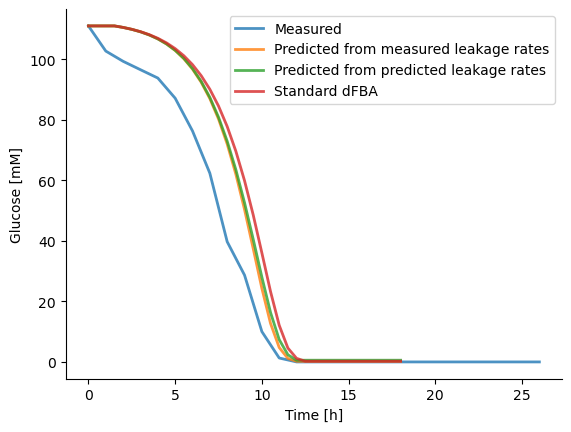

In [50]:
plt.plot(df_glucose.index, df_glucose['Glucose mM'], label = 'Measured', lw = 2, alpha = 0.8)
plt.plot(dt*D.concentrations_df.index, D.concentrations_df['M_glc__D_e'], label = 'Predicted from measured leakage rates', lw = 2, alpha = 0.8)
plt.plot(dt*De.concentrations_df.index, De.concentrations_df['M_glc__D_e'], label = 'Predicted from predicted leakage rates', lw = 2, alpha = 0.8)
plt.plot(dt*D0.concentrations_df.index, D0.concentrations_df['M_glc__D_e'], label = 'Standard dFBA', lw = 2, alpha = 0.8)
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Glucose [mM]')
sns.despine()

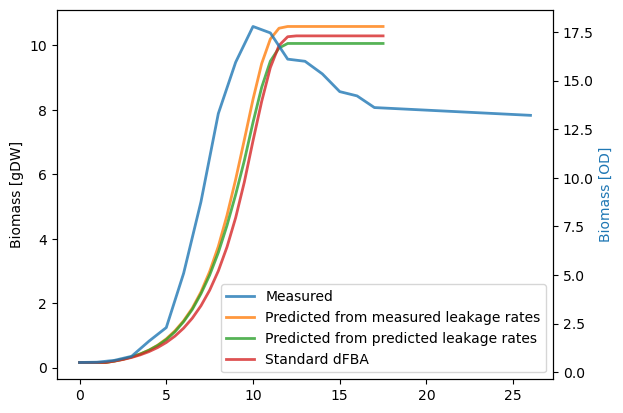

In [51]:
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
ln1 = ax2.plot(df_OD.index, df_OD['OD mean'], label = 'Measured', lw = 2, alpha = 0.8)
ln2 = ax.plot(D.biomass_df['Time'], D.biomass_df['E_coli'],
        label = 'Predicted from measured leakage rates', lw = 2, alpha = 0.8, c = 'C1')
ln3 = ax.plot(De.biomass_df['Time'], De.biomass_df['E_coli'], label = 'Predicted from predicted leakage rates', lw = 2, alpha = 0.8, c = 'C2')
ln4 = ax.plot(D0.biomass_df['Time'], D0.biomass_df['E_coli'], label = 'Standard dFBA', lw = 2, alpha = 0.8, c = 'C3')
# added these three lines
lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.xlabel('Time [h]')
ax.set_ylabel('Biomass [gDW]')
ax2.set_ylabel('Biomass [OD]')
ax2.yaxis.label.set_color(ln1[0].get_color())

# sns.despine()

# Plot

In [52]:
n = 18
timepoints = df_exometabolites.index[:n].values

In [53]:
mets_to_plot = {}
for met_abbr, met_id in met_abrv_to_id.items():
    try:
        measured_conc = df_exometabolites.loc[:n, met_abbr]*1e-3
    except KeyError:
        continue
        
    try:
        estimated_conc = D.concentrations_df[f'M_{met_id}_e']
    except KeyError:
        continue

    try:
        estimated_conc2 = De.concentrations_df[f'M_{met_id}_e']
    except KeyError:
        # estimated_conc_idx = np.zeros(len(measured_conc))*np.nan
        continue
    mets_to_plot[met_abbr] = met_id

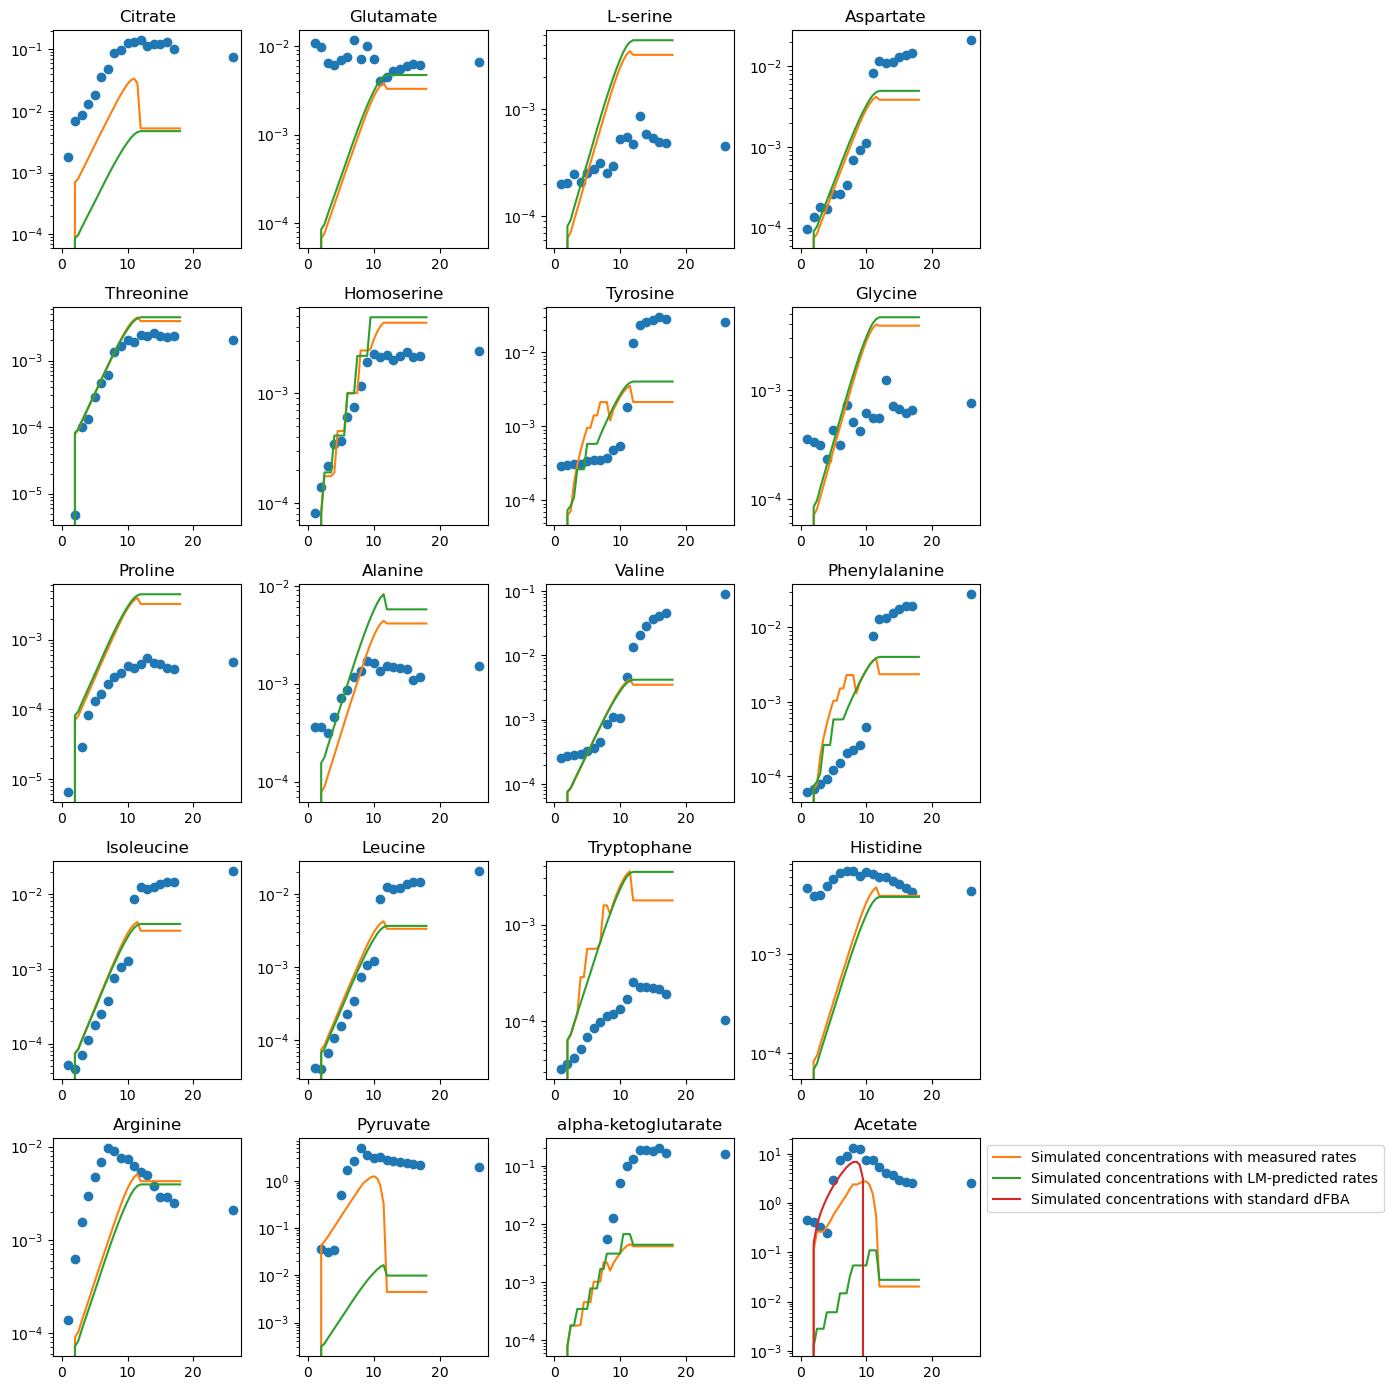

In [70]:
N = len(mets_to_plot)
fig, axes = plt.subplots(5,4, figsize = (10, 14))
axes = axes.flatten()
for i, (met_abbr, met_id) in enumerate(mets_to_plot.items()):
    measured_conc = df_exometabolites.loc[:, met_abbr]*1e-3
    estimated_conc = D.concentrations_df[f'M_{met_id}_e']
    estimated_conc2 = De.concentrations_df[f'M_{met_id}_e']
    try:
        estimated_conc3 = D0.concentrations_df[f'M_{met_id}_e']
    except KeyError:
        estimated_conc3 = np.zeros(len(estimated_conc2))*np.nan
    ln1 = axes[i].scatter(measured_conc.index, measured_conc, label = 'Measured concentrations')
    ln2 = axes[i].plot(estimated_conc.index*dt, estimated_conc, c = 'C1', label = 'Simulated concentrations with measured rates')
    ln3 = axes[i].plot(estimated_conc2.index*dt, estimated_conc2, c = 'C2', label = 'Simulated concentrations with LM-predicted rates')
    if np.sum(np.isnan(estimated_conc3))< len(estimated_conc3)-2:
        ln4 = axes[i].plot(estimated_conc3.index*dt, estimated_conc3, c = 'C3', label = 'Simulated concentrations with standard dFBA')
    axes[i].set_yscale('log')
    axes[i].set_title(met_abrv_to_name[met_abbr])
    
plt.tight_layout()
lns = ln2+ln3+ln4
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0, bbox_to_anchor = (1,1))

In [55]:
data = []
idx = np.where((D.concentrations_df.index*dt).isin(timepoints))
# timepoints = df_exometabolites.
for met_abbr, met_id in met_abrv_to_id.items():
    try:
        measured_conc = df_exometabolites.loc[:n, met_abbr]*1e-3
    except KeyError:
        continue
        
    try:
        estimated_conc = D.concentrations_df[f'M_{met_id}_e']
    except KeyError:
        estimated_conc_idx = np.zeros(len(measured_conc))*np.nan
        continue
    else:
        estimated_conc_idx = list(estimated_conc.loc[idx])

    try:
        estimated_conc2 = De.concentrations_df[f'M_{met_id}_e']
    except KeyError:
        # estimated_conc_idx = np.zeros(len(measured_conc))*np.nan
        continue
    else:
        estimated_conc_idx2 = list(estimated_conc2.loc[idx])

    try:
        estimated_conc3 = D0.concentrations_df[f'M_{met_id}_e']
    except KeyError:
        estimated_conc_idx3 = np.zeros(len(measured_conc))*np.nan
    else:
        estimated_conc_idx3 = list(estimated_conc3.loc[idx])
    
    for i in range(n):
        data.append([met_abrv_to_name[met_abbr], 'Measured', measured_conc[i], i])
        data.append([met_abrv_to_name[met_abbr], 'Predicted from measure leakage', 
                     estimated_conc_idx[i], i])
        data.append([met_abrv_to_name[met_abbr], 'Predicted from predicted leakage',
                     estimated_conc_idx2[i], i])
        data.append([met_abrv_to_name[met_abbr], 'Standard dFBA',
                     estimated_conc_idx3[i], i])
    
df = pd.DataFrame(data, columns = ['Metabolite', 'Method', 'Concentration [mM]', 'Time'])
        


2023-12-13 10:24:08 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



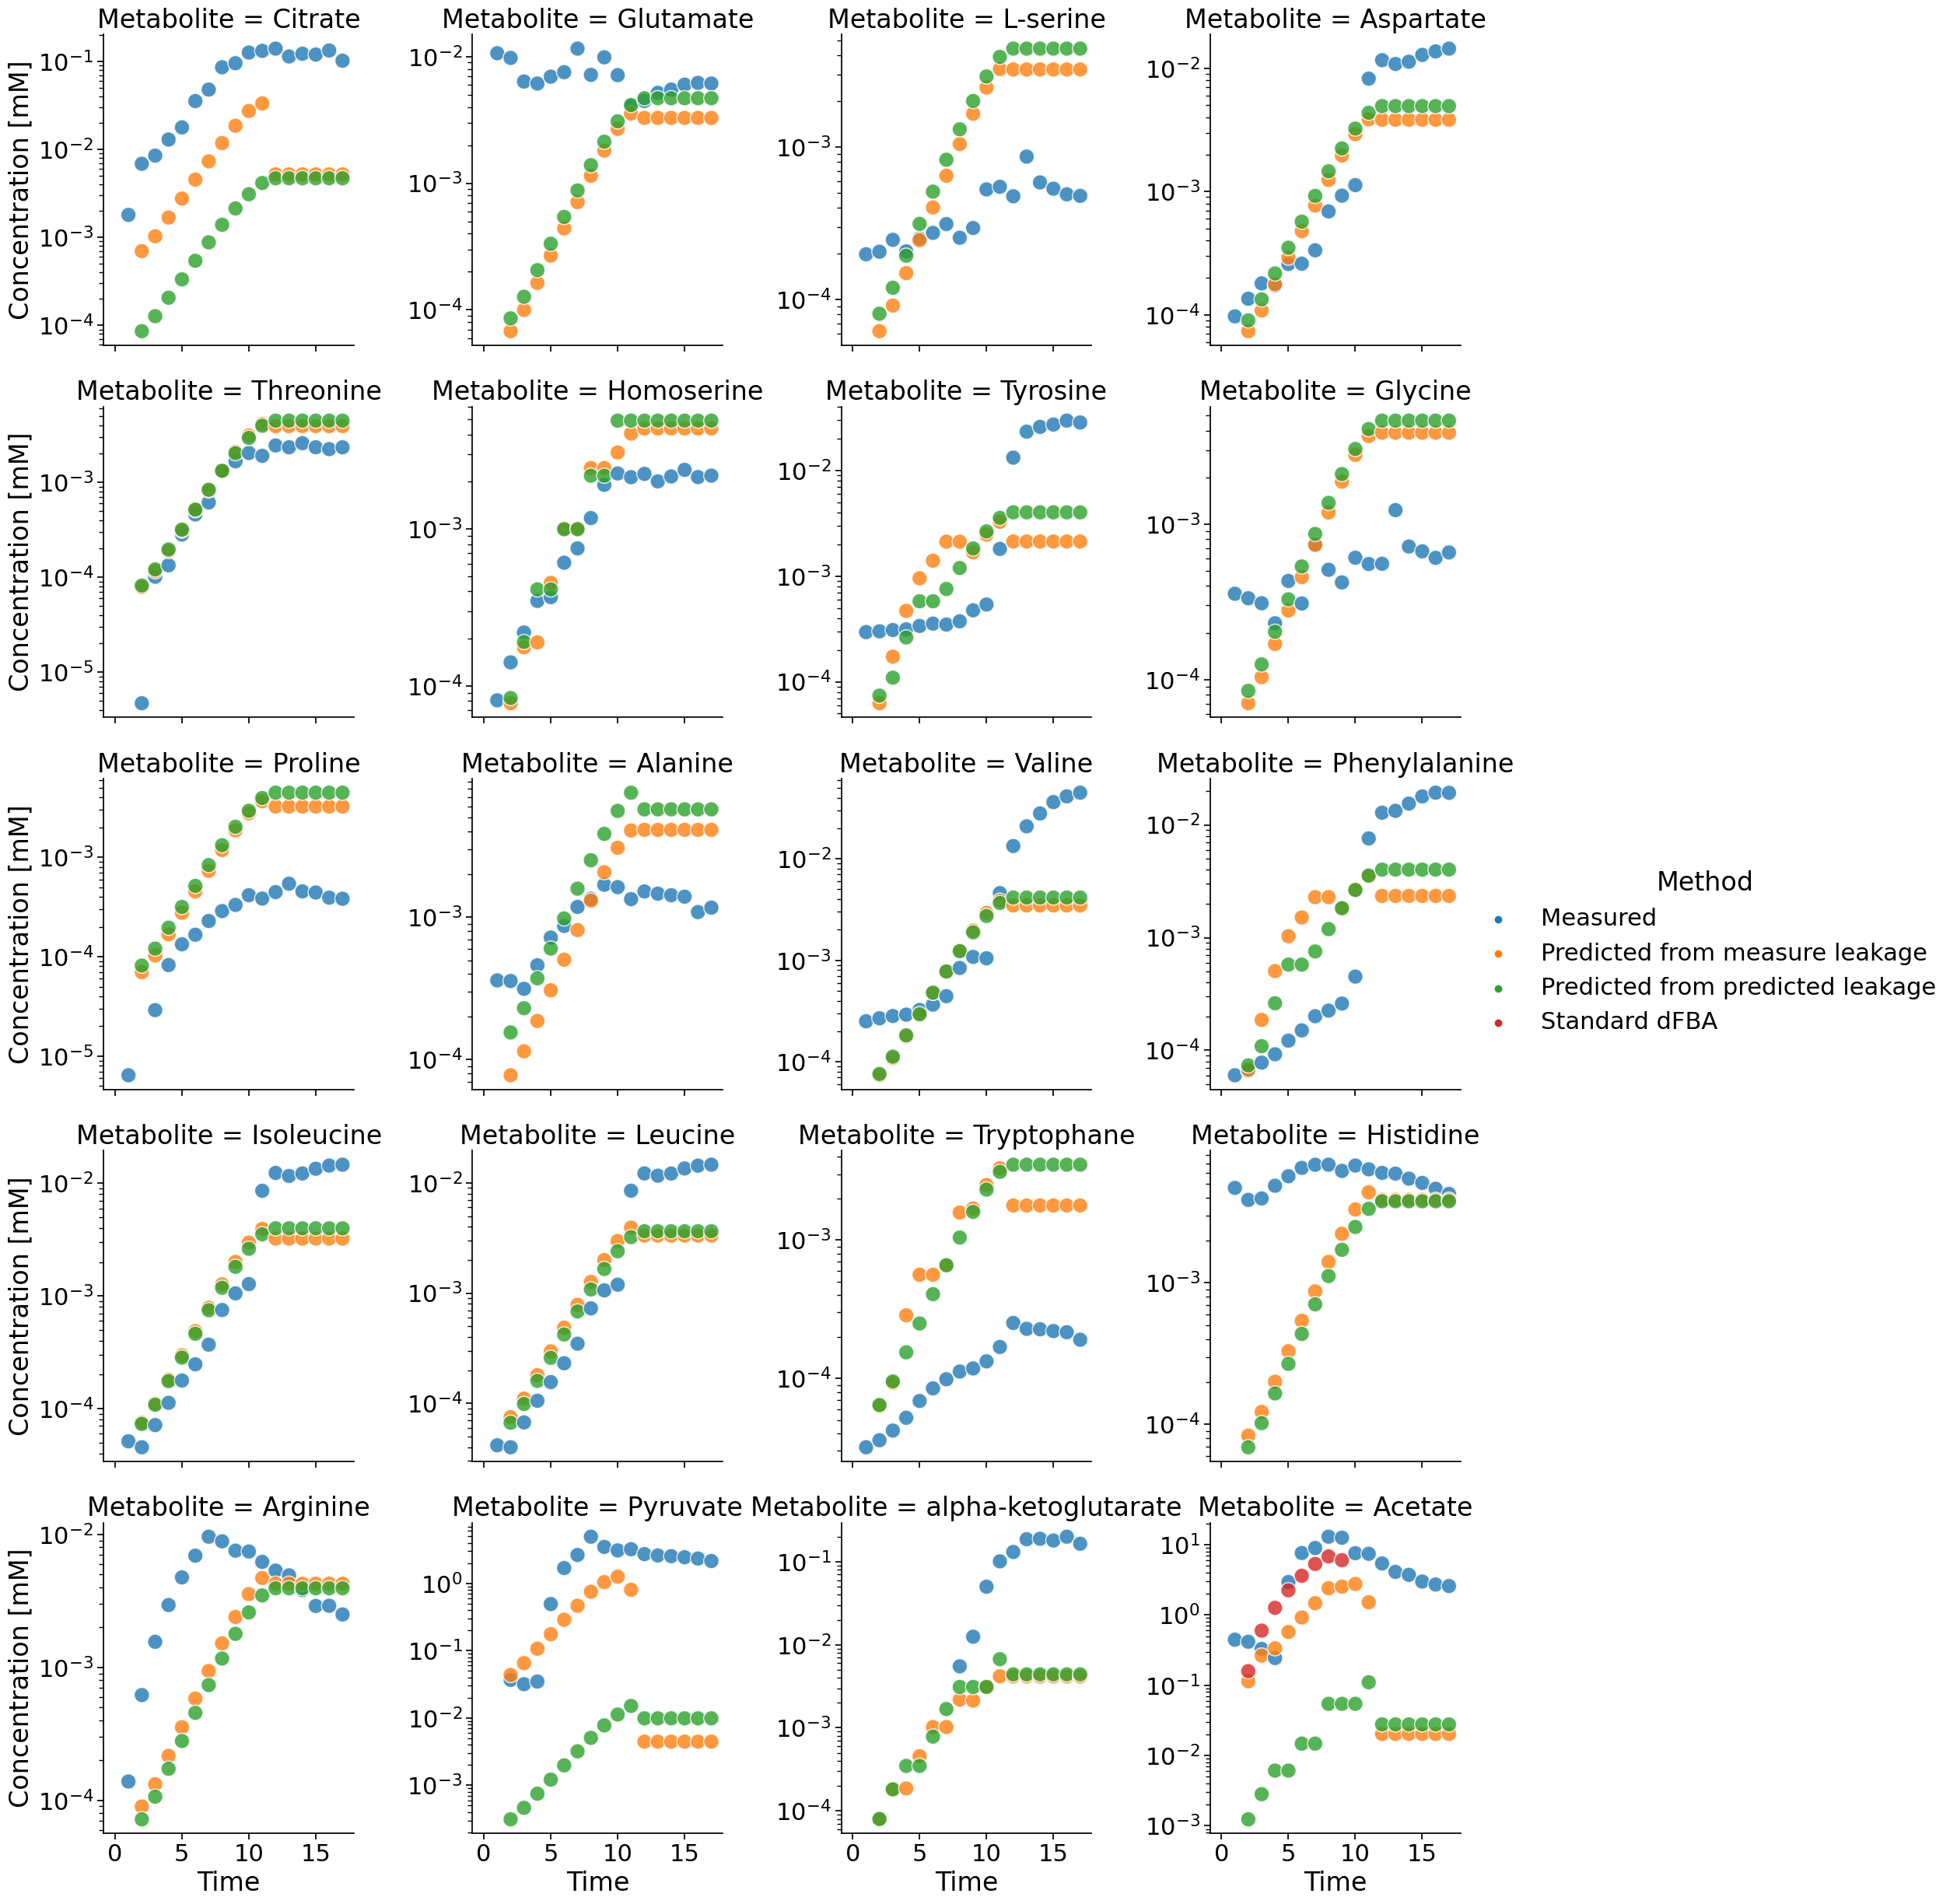

In [56]:
with sns.plotting_context("notebook", font_scale=2):
    g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':False}, hue = 'Method', s = 200, alpha = 0.8)
for ax in g.axes:
    ax.set_yscale('log')
        # ax.set_ylim(1e-5, 1)

2023-12-13 10:24:11 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



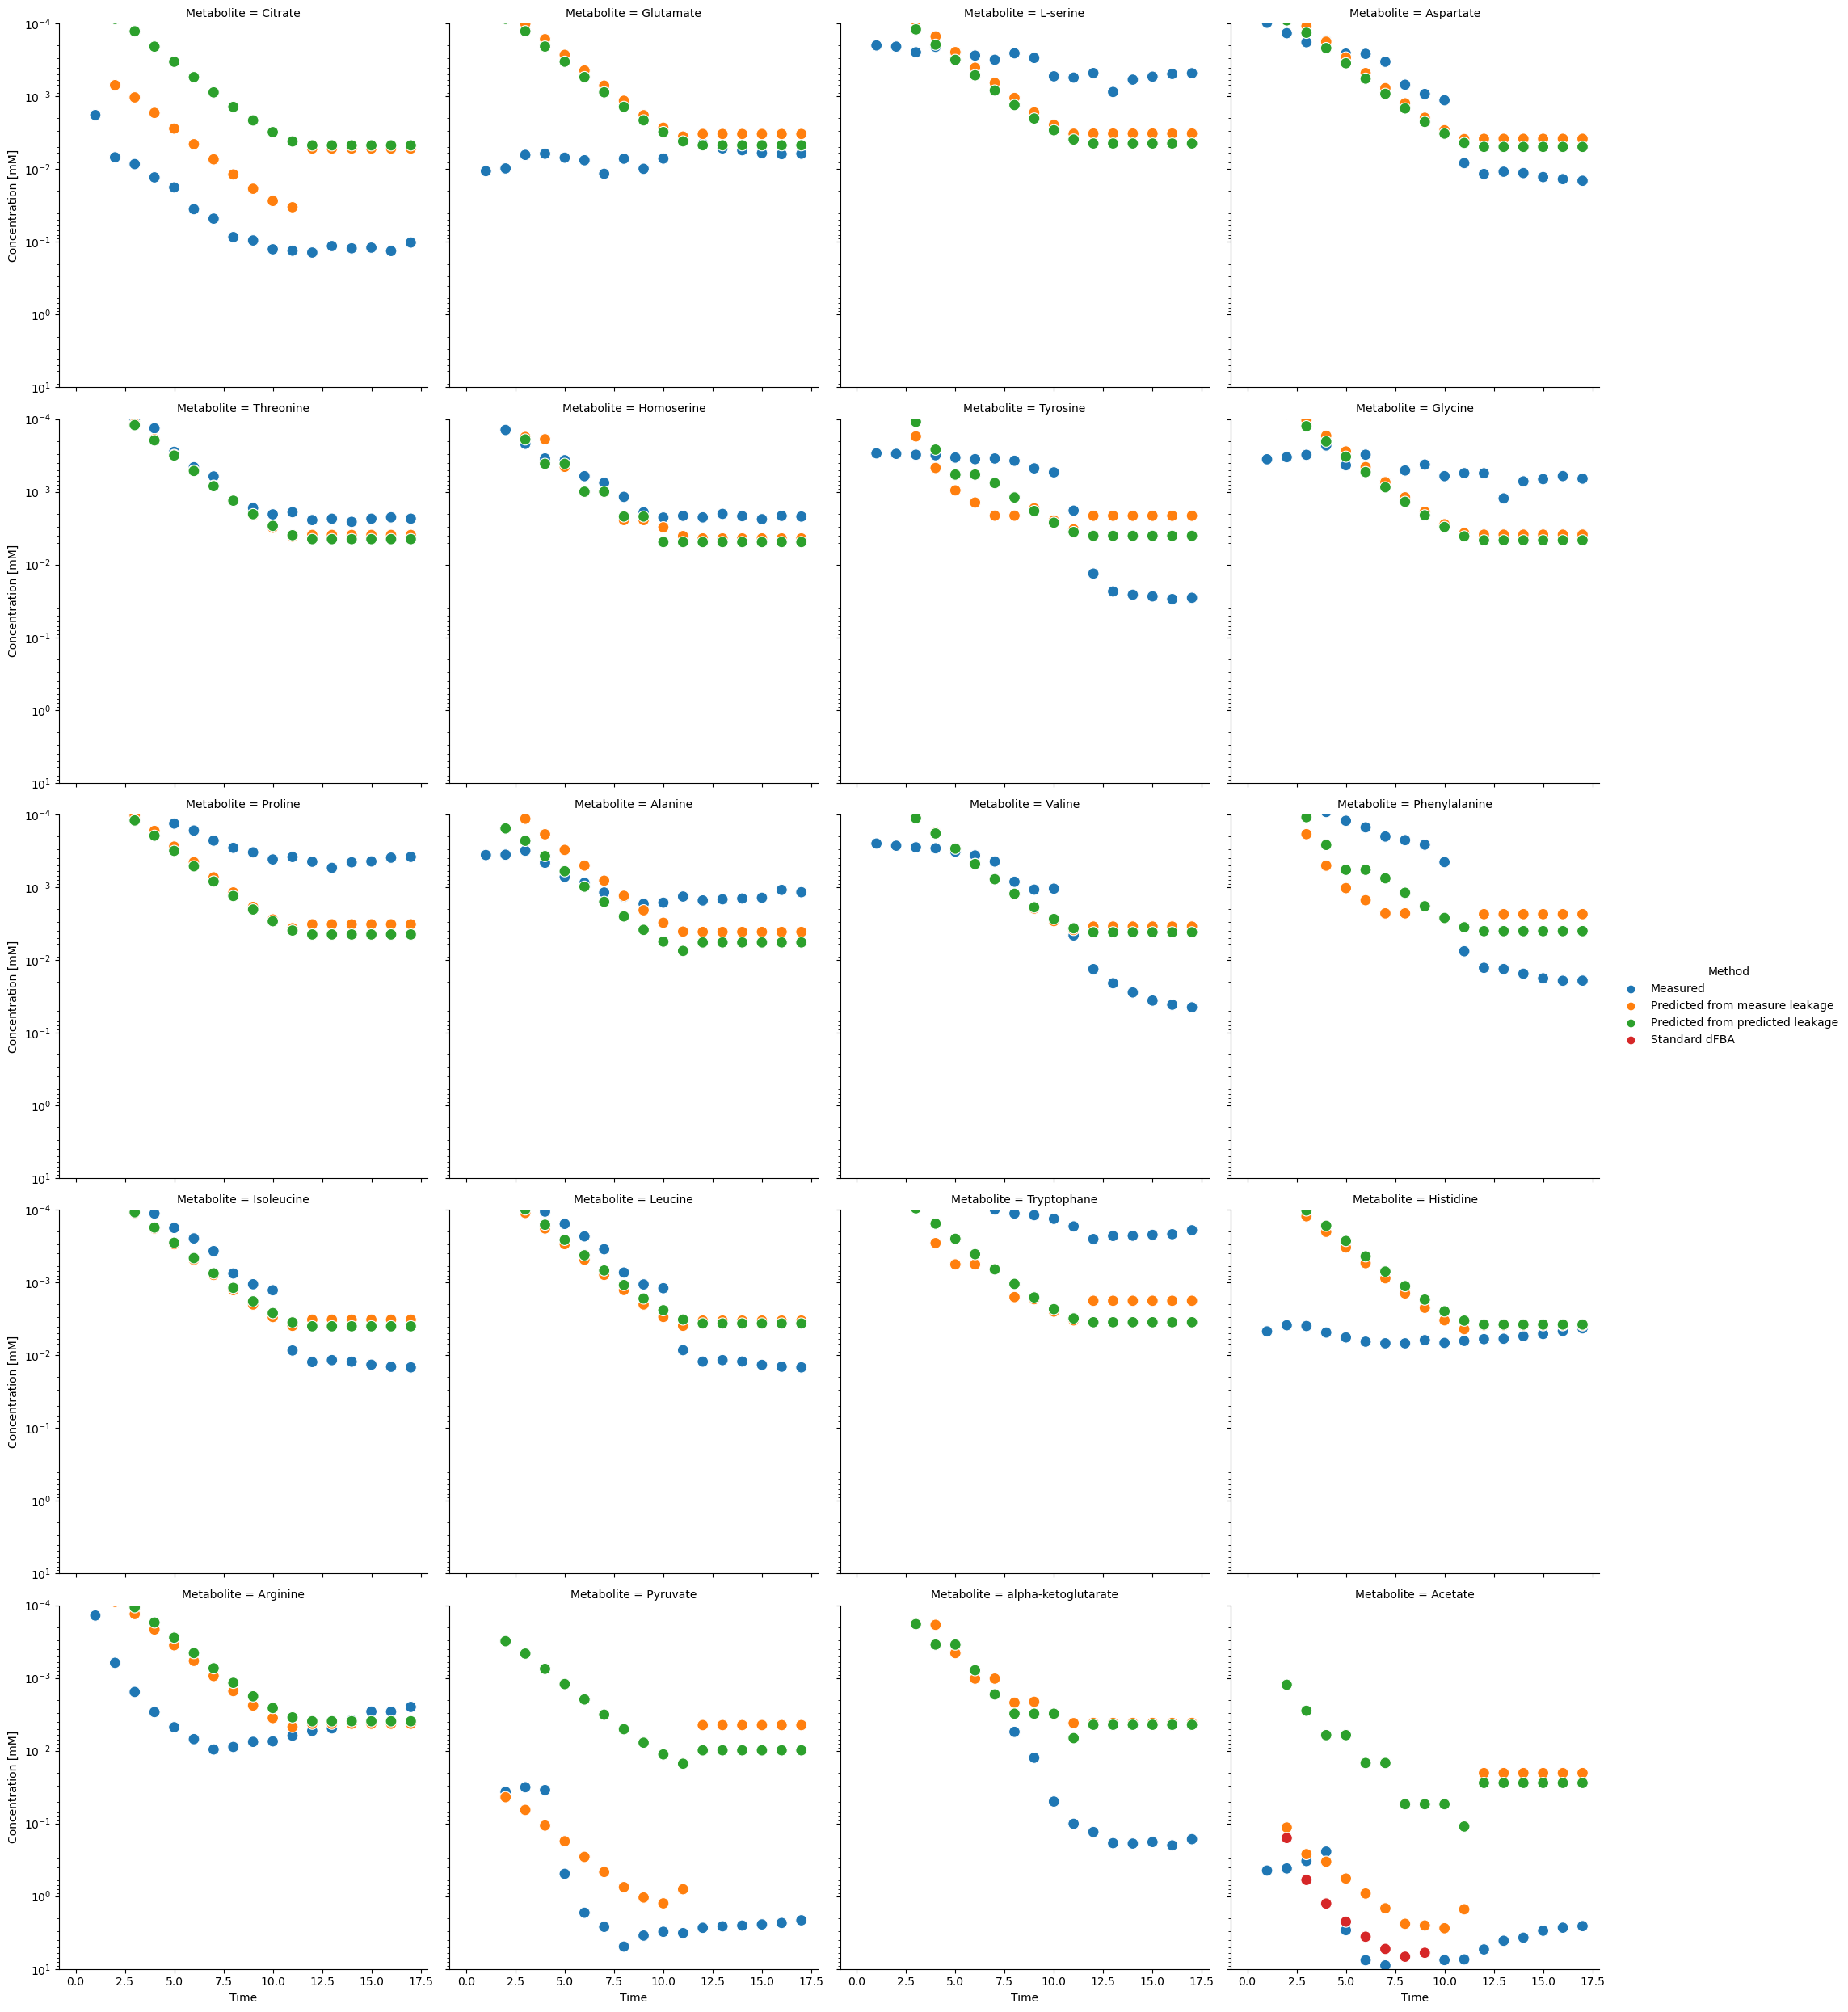

In [57]:
g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':True}, hue = 'Method', s = 100)
for ax in g.axes:
    ax.set_yscale('log')
    ax.set_ylim(10, 1e-4)

2023-12-13 10:24:14 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



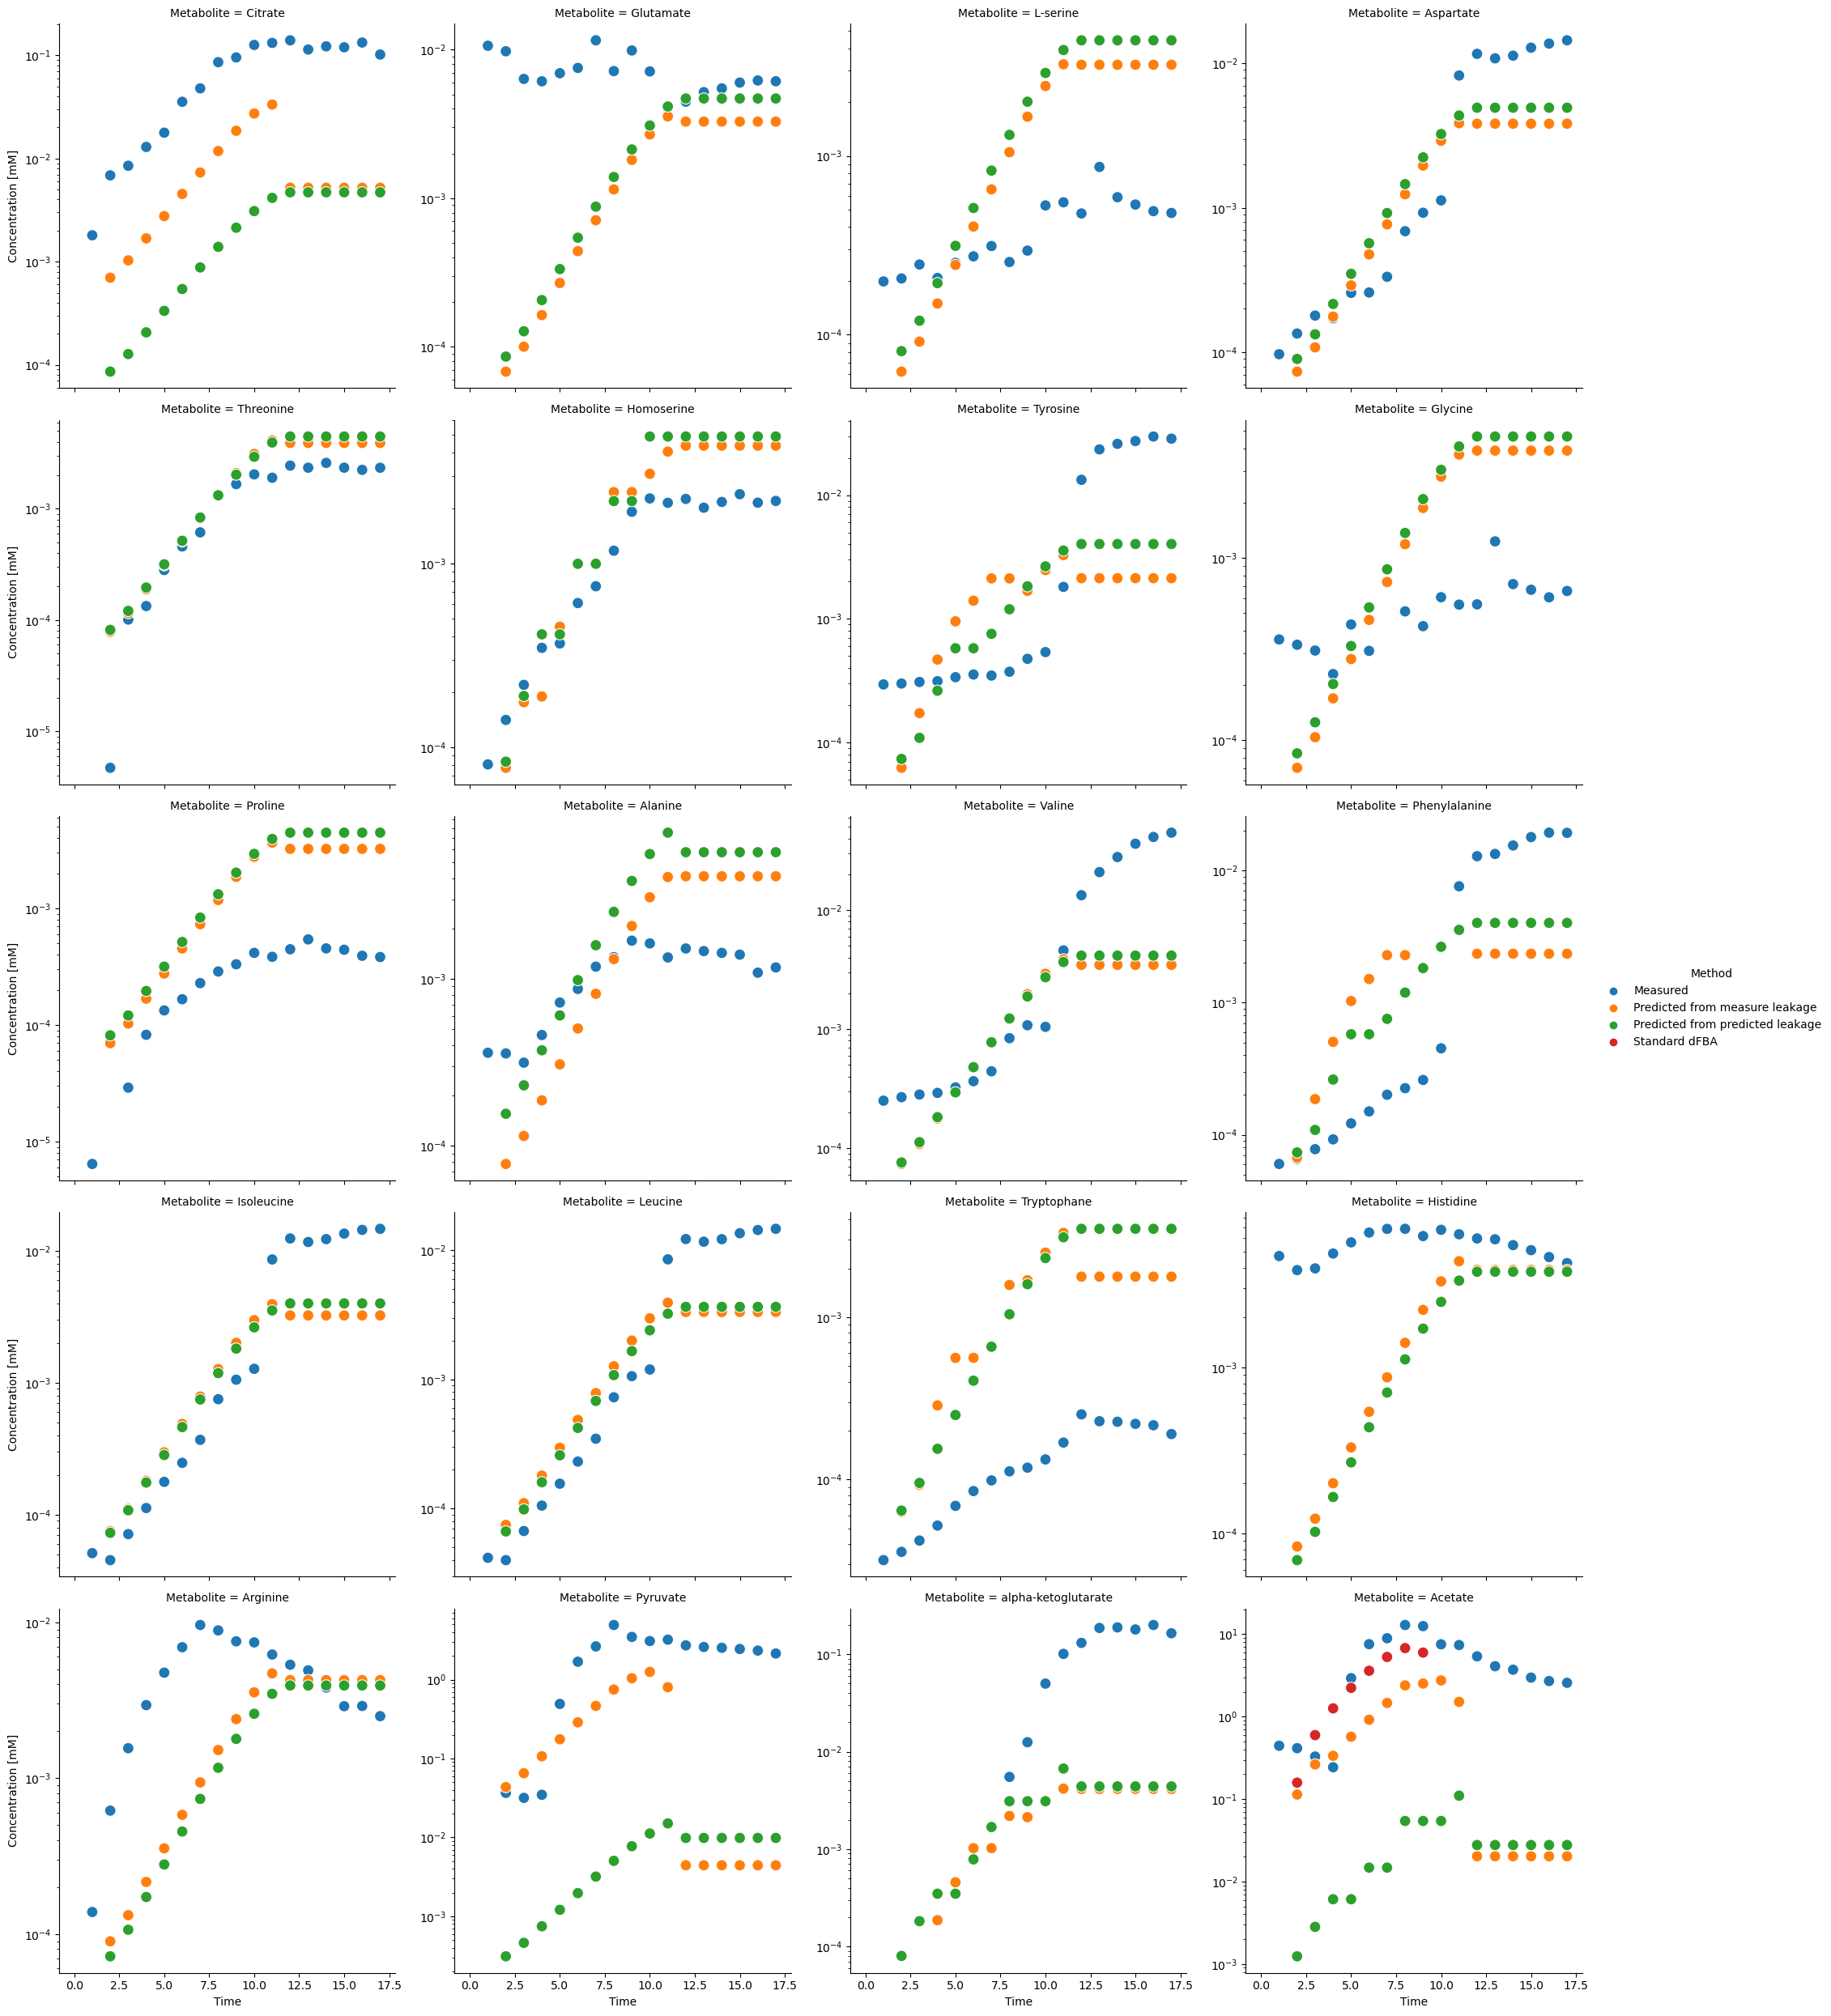

In [58]:
g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':False}, hue = 'Method', s = 100)
for ax in g.axes:
    ax.set_yscale('log')

2023-12-13 10:24:18 WARNING:py.warnings /Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



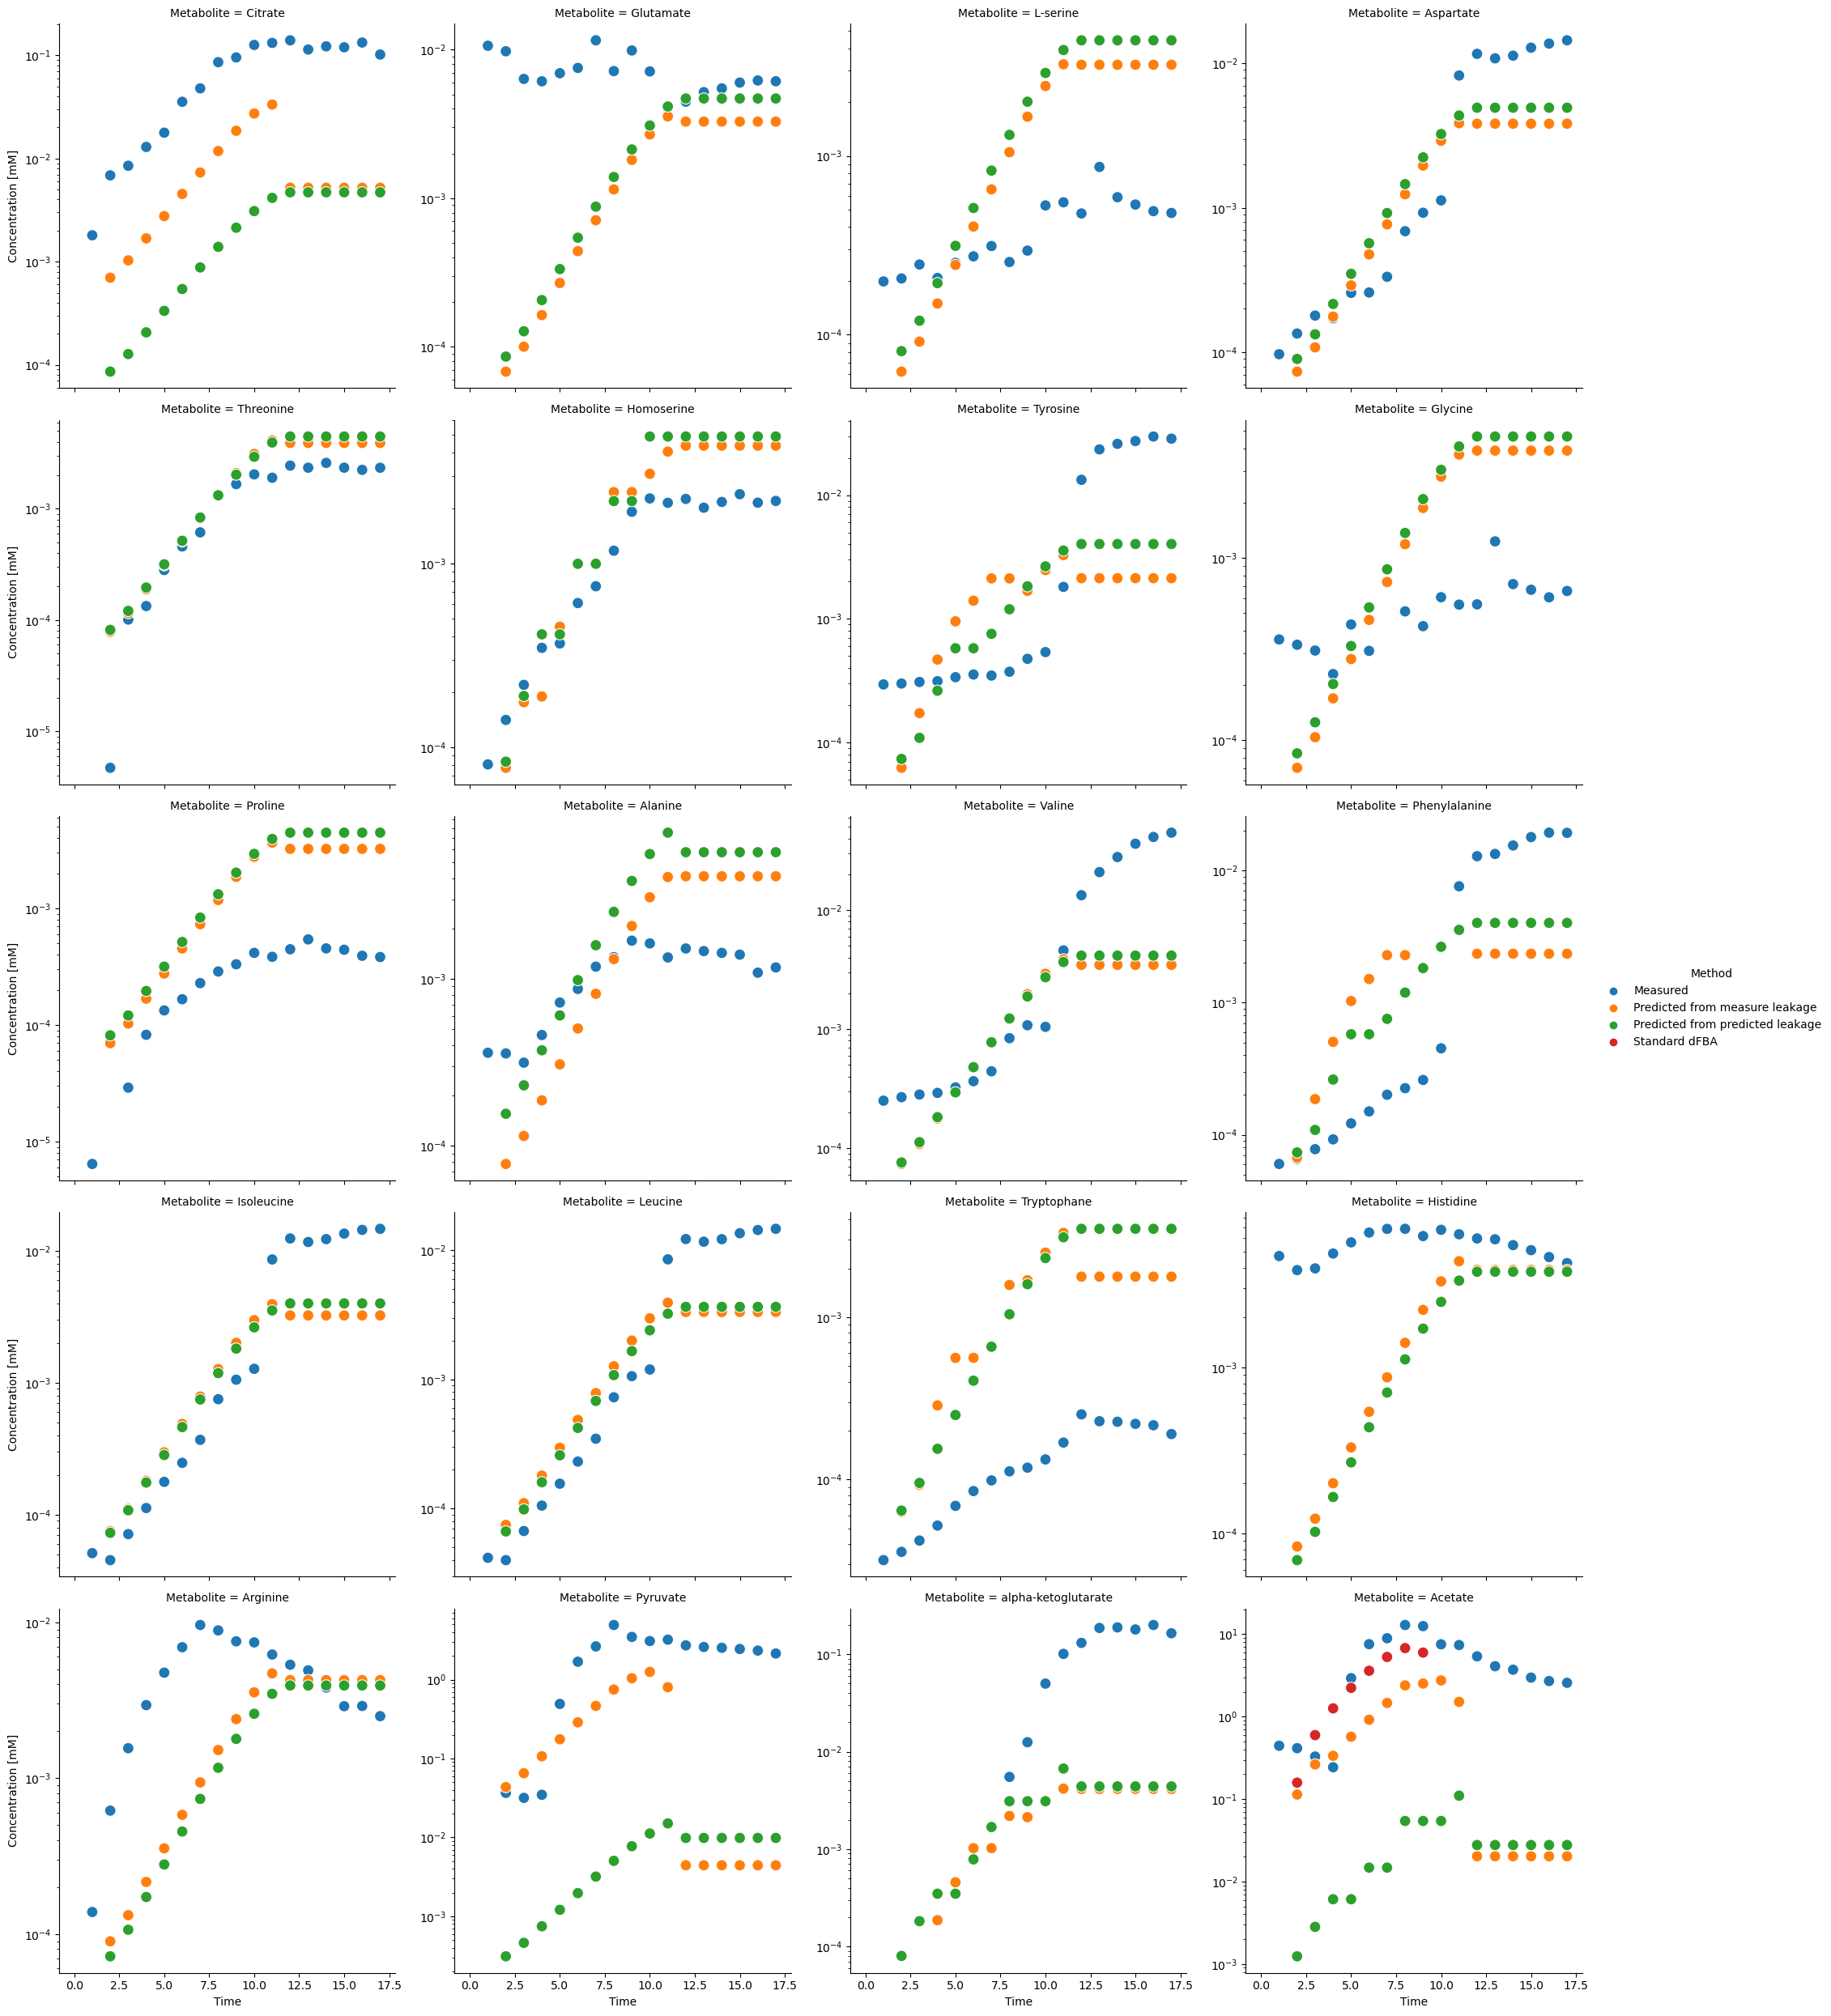

In [59]:
g = sns.relplot(data = df, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, 
            facet_kws={'sharey':False}, hue = 'Method', s = 100)
for ax in g.axes:
    ax.set_yscale('log')

In [60]:
estimated_conc_idx

[0.0,
 0.0,
 0.1135802061271071,
 0.2637453589386204,
 0.3352185609008876,
 0.5713021761603108,
 0.9183018188264853,
 1.4676121992481619,
 2.3963426647842385,
 2.524348919723064,
 2.7536952011832807,
 1.5131335733885742,
 0.020277240842372257,
 0.020277240842372257,
 0.020277240842372257,
 0.020277240842372257,
 0.020277240842372257,
 0.020277240842372257]

In [61]:
estimated_conc.iloc[idx]

0     0.000000
2     0.000000
4     0.113580
6     0.263745
8     0.335219
10    0.571302
12    0.918302
14    1.467612
16    2.396343
18    2.524349
20    2.753695
22    1.513134
24    0.020277
26    0.020277
28    0.020277
30    0.020277
32    0.020277
34    0.020277
Name: M_ac_e, dtype: float64

In [62]:
estimated_conc

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.113580
5     0.263745
6     0.263745
7     0.263745
8     0.335219
9     0.424804
10    0.571302
11    0.729038
12    0.918302
13    1.167423
14    1.467612
15    1.939492
16    2.396343
17    2.373319
18    2.524349
19    2.762317
20    2.753695
21    2.354174
22    1.513134
23    0.550282
24    0.020277
25    0.020277
26    0.020277
27    0.020277
28    0.020277
29    0.020277
30    0.020277
31    0.020277
32    0.020277
33    0.020277
34    0.020277
35    0.020277
36    0.020277
Name: M_ac_e, dtype: float64

In [63]:
pairs = {'ACT'}

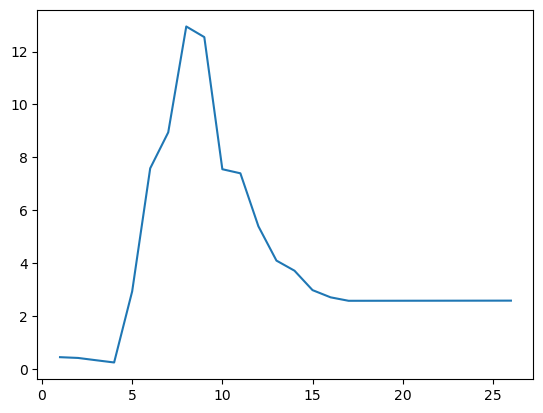

In [64]:
plt.plot(df_exometabolites['ACT']*1e-3)

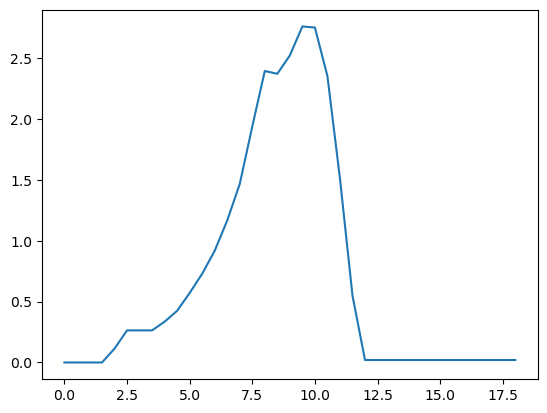

In [65]:
plt.plot(D.concentrations_df.index*dt, D.concentrations_df['M_ac_e'])

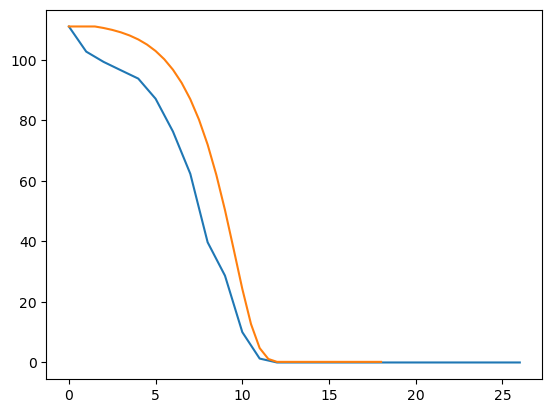

In [66]:
plt.plot(df_glucose.index, df_glucose['Glucose mM'])
plt.plot(dt*D.concentrations_df.index, D.concentrations_df['M_glc__D_e'])